In [1]:
import numpy as np
import time
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

from keras.models import Sequential, Input, Model, load_model
from keras.backend import constant
from keras.layers import Dense, Activation, Flatten, Reshape, Lambda
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
a = np.load('celeba_aligned_160.npz')
pictures = a.f.arr_0
# embeddings_file = np.load('lfw_aligned_embeddings.npz')
# embeddings = embeddings_file.f.arr_0

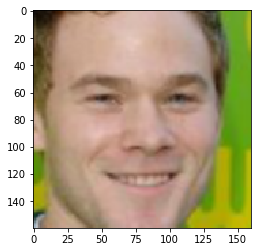

In [3]:
plt.imshow(pictures[0])

In [4]:
def upsample_to_160():
    import cv2
    aligned = list()
    for i in range(len(pictures)):
        if i % 10000 == 0:
            print(str(i))
        aligned.append(cv2.resize(pictures[i], (160, 160)))
    return aligned

In [6]:
# np.savez_compressed('celeba_aligned_160.npz', aligned)

In [55]:
model_file = 'model/facenet_keras.h5'
FRmodel = load_model(model_file)
# summarize input and output shape
print(FRmodel.inputs)
print(FRmodel.outputs)
# FRmodel.load_weights("model/facenet_keras_weights.h5")






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
[<tf.Tensor 'input_1_2:0' shape=(?, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm_1/cond/Merge:0' shape=(?, 128) dtype=float32>]


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [49]:
FRmodel.layers[421].output

<tf.Tensor 'Block8_6_ScaleSum/add:0' shape=(?, 3, 3, 1792) dtype=float32>

In [58]:
facenet_early = Model(FRmodel.input, [FRmodel.get_layer('Block8_6_Conv2d_1x1').output, FRmodel.output])

In [88]:
facenet_early.outputs[1].name

'Bottleneck_BatchNorm_1/cond/Merge:0'

In [408]:
FRmodel.get_layer('Block8_4_Activation')

In [443]:
facenet_guiding = Model(FRmodel.input, FRmodel.get_layer('Block8_4_Activation').output)

In [444]:
guides_early = facenet_guiding.predict(pictures_temp[0:500])

In [415]:
# np.savez_compressed('celeba_guides.npz', guides)

In [66]:
d[1].shape

(2, 128)

In [8]:
# get embeddings from celeba images
# embeddings = FRmodel.predict(aligned)
# center embeddings around 0
# embeddings_norm = (embeddings - np.mean(embeddings))/ np.std(embeddings)
embeddings_dat = np.load('celeba_aligned_160_embeddings.npz')
embeddings = embeddings_dat.f.arr_0

In [33]:
# pictures_norm = (pictures - 127.5) / 127.5

In [59]:
pictures.shape

(195354, 160, 160, 3)

In [4]:
pictures_norm = pictures[:50000].astype(np.float32)

In [69]:
pictures_temp = pictures[:50000]

In [70]:
embeddings = facenet_early.predict(pictures_temp)

In [74]:
embeddings[0].shape

(50000, 3, 3, 1792)

In [83]:
# np.savez_compressed('celeba_cropped_50k_emb.npz', embeddings[0], embeddings[1])

In [6]:
# pictures_norm = pictures_norm.astype(np.float32)

In [89]:
# we get memory errors for larger subset of data
# for i in range(50):
#     print(i)
#     pictures_norm[1000*i:1000*(i+1)] = (pictures_norm[1000*i:1000*(i+1)] - 127.5) / 127.5

In [7]:
np.savez_compressed('celeba_cropped_50k.npz', pictures_norm)

In [2]:
a = np.load('celeba_cropped_50k.npz')
pictures_norm = a.f.arr_0

In [ ]:
# generator.fit(x=embeddings_norm, y=img_norm, epochs=10, batch_size=64)

In [ ]:
# test = generator.predict(embeddings[5:6])
# plt.imshow(test[0]*0.5+0.5)

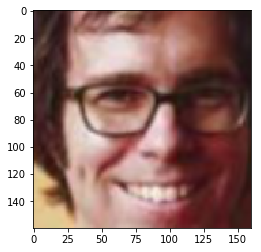

In [7]:
plt.imshow(pictures_norm[6]*0.5+0.5)

In [5]:
embeddings = []

In [16]:
from keras.models import Sequential, Model, load_model
from keras.layers import UpSampling2D, Conv2D, Activation, BatchNormalization, Reshape, Dense, Input, LeakyReLU, Dropout, Flatten, ZeroPadding2D
from keras.optimizers import Adam

import glob
from PIL import Image
import numpy as np
import os
import argparse
from ast import literal_eval

from scipy.misc import imsave


class DCGAN:
    def __init__(self, discriminator_path, generator_path, output_directory, img_size):
        self.img_size = img_size
        self.upsample_layers = 5
        self.starting_filters = 64
        self.kernel_size = 3
        self.channels = 3
        self.discriminator_path = discriminator_path
        self.generator_path = generator_path
        self.output_directory = output_directory

    def build_generator(self):
        noise_shape = (100,)

        # This block of code can be a little daunting, but essentially it automatically calculates the required starting
        # array size that will be correctly upscaled to our desired image size.
        #
        # We have 5 Upsample2D layers which each double the images width and height, so we can determine the starting
        # x size by taking (x / 2^upsample_count) So for our target image size, 256x192, we do the following:
        # x = (192 / 2^5), y = (256 / 2^5) [x and y are reversed within the model]
        # We also need a 3rd dimension which is chosen relatively arbitrarily, in this case it's 64.
        model = Sequential()
        model.add(
            Dense(self.starting_filters * (self.img_size[0] // (2 ** self.upsample_layers))  *  (self.img_size[1] // (2 ** self.upsample_layers)),
                  activation="relu", input_shape=noise_shape))
        model.add(Reshape(((self.img_size[0] // (2 ** self.upsample_layers)),
                           (self.img_size[1] // (2 ** self.upsample_layers)),
                           self.starting_filters)))
        model.add(BatchNormalization(momentum=0.8))

        model.add(UpSampling2D())  # 6x8 -> 12x16
        model.add(Conv2D(1024, kernel_size=self.kernel_size, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(UpSampling2D())  # 12x16 -> 24x32
        model.add(Conv2D(512, kernel_size=self.kernel_size, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(UpSampling2D())  # 24x32 -> 48x64
        model.add(Conv2D(256, kernel_size=self.kernel_size, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(UpSampling2D())  # 48x64 -> 96x128
        model.add(Conv2D(128, kernel_size=self.kernel_size, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(UpSampling2D())  # 96x128 -> 192x256
        model.add(Conv2D(64, kernel_size=self.kernel_size, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(32, kernel_size=self.kernel_size, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(self.channels, kernel_size=self.kernel_size, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_size[0], self.img_size[1], self.channels)

        model = Sequential()

        model.add(Conv2D(32, kernel_size=self.kernel_size, strides=2, input_shape=img_shape, padding="same"))  # 192x256 -> 96x128
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, kernel_size=self.kernel_size, strides=2, padding="same"))  # 96x128 -> 48x64
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(128, kernel_size=self.kernel_size, strides=2, padding="same"))  # 48x64 -> 24x32
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(256, kernel_size=self.kernel_size, strides=1, padding="same"))  # 24x32 -> 12x16
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(512, kernel_size=self.kernel_size, strides=1, padding="same"))  # 12x16 -> 6x8
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

    def build_gan(self, get_models=True):
        optimizer = Adam(0.00002, 0.5)

        # See if the specified model paths exist, if they don't then we start training new models
        print("building gan")
        if get_models:
            if os.path.exists(self.discriminator_path) and os.path.exists(self.generator_path):
                self.discriminator = load_model(self.discriminator_path)
                print("Loaded generator")
                self.generator = load_model(self.generator_path)
                print("Loaded models...")
            else:
                print("creating from scratch")
                self.discriminator = self.build_discriminator()
                self.discriminator.compile(loss='binary_crossentropy',
                                           optimizer=optimizer,
                                           metrics=['accuracy'])

                self.generator = self.build_generator()
                self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # These next few lines setup the training for the GAN model
        z = Input(shape=(100,))
        img = self.generator(z)

        self.discriminator.trainable = False

        valid = self.discriminator(img)

        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def build_identity_loss(self):
        print("creating identity loss...")
        optimizer = Adam(0.0002, 0.5)

        # See if the specified model paths exist, if they don't then we start training new models
        self.identitymodel = facenet_early
        self.identitymodel.trainable = False
#         self.identitymodel.compile(loss='sparse_categorical_crossentropy',
#                                    optimizer=optimizer,
#                                    metrics=['accuracy'])

        # These next few lines setup the training for the ip model
        z = Input(shape=(128,))
        img = self.generator(z)
        
        un_norm = Lambda(lambda x: (x * constant(127.5))+constant(127.5))
        img = un_norm(img)
        
        img_emb = self.identitymodel(img)

        self.id_combined = Model(z, img_emb)
        
        losses = {
#             "Block8_6_Conv2d_1x1_1/BiasAdd:0": "mean_squared_error",
#             "Bottleneck_BatchNorm_1/cond/Merge:0": "mean_squared_error",
            "model_10": "mean_squared_error",
        }
        lossWeights = {
#             "Block8_6_Conv2d_1x1_1/BiasAdd:0": 1.0,
#             "Bottleneck_BatchNorm_1/cond/Merge:0": 1.0
            "model_10": 0.01,
        }
        
        self.id_combined.compile(optimizer=optimizer, loss=losses, loss_weights=lossWeights, metrics=["accuracy"])
                                 #, loss_weights=lossWeights,
                                 

    def load_imgs(self, image_path):
        X_train = []
        for i in glob.glob(image_path):
            img = Image.open(i)
            img = np.asarray(img)
            X_train.append(img)
        return np.asarray(X_train)

    def train(self, epochs, image_path, batch_size=32, save_interval=50, recreate_model=False, get_modelss=True):
        if recreate_model:
            self.build_gan(get_models=get_modelss)
#             self.build_identity_loss()
#         X_train = self.load_imgs(image_path)
        X_train = [pictures_norm, embeddings]
        print("Training Data Shape: ", X_train[0].shape)

        # Rescale images from -1 to 1
#         X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        half_batch = batch_size // 2

        for epoch in range(epochs):


            # Train Generator
            noise = np.random.normal(0, 1, (batch_size, 100))
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))
            
#             idx_emb = np.random.randint(0, X_train[0].shape[0], batch_size)
#             embs_gen = X_train[1][1][idx_emb]
#             g_loss = self.combined.train_on_batch(embs_gen, np.ones((batch_size, 1)))



            # Train Discriminator
            idx = np.random.randint(0, X_train[0].shape[0], half_batch)
            imgs = X_train[0][idx]
            
#             idx2 = np.random.randint(0, X_train[0].shape[0], half_batch)
#             embs = [X_train[1][0][idx2], X_train[1][1][idx2]]
            
#             idx2 = np.random.randint(0, X_train[0].shape[0], half_batch*2)
#             imgs2 = X_train[0][idx2]

            # Sample noise and generate a half batch of new images
            noise = np.random.normal(0, 1, (half_batch, 100))
            gen_imgs = self.generator.predict(noise)
#             gen_imgs_facenet = self.generator.predict(embs[1])

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
#             d_loss_facenet = self.discriminator.train_on_batch(gen_imgs_facenet, np.zeros((half_batch, 1)))
#             d_loss = 0.5 * np.add(d_loss_real, 0.5 * np.add(d_loss_fake, d_loss_facenet))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # using noise as input, and random guides as desired output
#             guide_dist = np.random.randint(0, guides.shape[0], half_batch)
#             rand_guides = guides[guide_dist]
#             id_loss = self.id_combined.train_on_batch(noise, X_train[1][1][idx])

            # Print progress
#             print(f"{epoch} [D loss: {d_loss[0]} | D Accuracy: {100 * d_loss[1]}] <ID: {id_loss[0]}, acc: {100*id_loss[1]}> [G loss: {g_loss}]")
            print(f"{epoch} [D loss: {d_loss[0]} | D Accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

            # If at save interval => save generated image samples, save model files
            if epoch % (save_interval) == 0:

                self.save_imgs(epoch)
#                 self.save_imgs_emb(epoch)

                save_path = self.output_directory + "/models"
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                self.discriminator.save(save_path + "/discrim.h5")
                self.generator.save(save_path + "/generat.h5")

    def gene_imgs(self, count):
        # Generate images from the currently loaded model
        noise = np.random.normal(0, 1, (count, 100))
        return self.generator.predict(noise)
    
    def gene_imgs_emb(self, count):
        # Generate images from the currently loaded model
        idx_emb = np.random.randint(0, embeddings[1].shape[0], count)
        embs_gen = embeddings[1][idx_emb]
        return self.generator.predict(embs_gen)

    def save_imgs(self, epoch):
        r, c = 5, 5

        # Generates r*c images from the model, saves them individually and as a gallery

        imgs = self.gene_imgs(r*c)
        imgs = 0.5 * imgs + 0.5

        for i, img_array in enumerate(imgs):
            path = f"{self.output_directory}/generated_{self.img_size[0]}x{self.img_size[1]}"
            if not os.path.exists(path):
                os.makedirs(path)
            imsave(path + f"/{epoch}_{i}.png", img_array)

        nindex, height, width, intensity = imgs.shape
        nrows = nindex // c
        assert nindex == nrows * c
        # want result.shape = (height*nrows, width*ncols, intensity)
        gallery = (imgs.reshape(nrows, c, height, width, intensity)
                  .swapaxes(1, 2)
                  .reshape(height * nrows, width * c, intensity))

        path = f"{self.output_directory}/gallery_generated_{self.img_size[0]}x{self.img_size[1]}"
        if not os.path.exists(path):
            os.makedirs(path)
        imsave(path + f"/{epoch}.png", gallery)
    
    def save_imgs_emb(self, epoch):
        r, c = 5, 5

        # Generates r*c images from the model, saves them individually and as a gallery

        imgs = self.gene_imgs_emb(r*c)
        imgs = 0.5 * imgs + 0.5

        for i, img_array in enumerate(imgs):
            path = f"{self.output_directory}/generated_emb_{self.img_size[0]}x{self.img_size[1]}"
            if not os.path.exists(path):
                os.makedirs(path)
            imsave(path + f"/{epoch}_{i}.png", img_array)

        nindex, height, width, intensity = imgs.shape
        nrows = nindex // c
        assert nindex == nrows * c
        # want result.shape = (height*nrows, width*ncols, intensity)
        gallery = (imgs.reshape(nrows, c, height, width, intensity)
                  .swapaxes(1, 2)
                  .reshape(height * nrows, width * c, intensity))

        path = f"{self.output_directory}/gallery_generated_emb_{self.img_size[0]}x{self.img_size[1]}"
        if not os.path.exists(path):
            os.makedirs(path)
        imsave(path + f"/{epoch}.png", gallery)

    def generate_imgs(self, count, threshold, modifier):
        self.build_gan()

        # Generates (count) images from the model ensuring the discriminator scores them between the threshold values
        # and saves them

        imgs = []
        for i in range(count):
            score = [0]
            while not(threshold[0] < score[0] < threshold[1]):
                img = self.gene_imgs(1)
                score = self.discriminator.predict(img)
            print("Image found: ", score[0])
            imgs.append(img)

        imgs = np.asarray(imgs).squeeze()
        imgs = 0.5 * imgs + 0.5

        print(imgs.shape)
        for i, img_array in enumerate(imgs):
            path = f"{self.output_directory}/generated_{threshold[0]}_{threshold[1]}"
            if not os.path.exists(path):
                os.makedirs(path)
            imsave(path + f"/{modifier}_{i}.png", img_array)

In [17]:
gan = DCGAN("gan_overnight/models/discrim.h5", "gan_overnight/models/generat.h5", "gan_overnight2", (160,160,3))

In [18]:
gan.train(epochs=20001, image_path="images/", batch_size=64, save_interval=100, recreate_model=True, get_modelss=True)


building gan
Loaded generator
Loaded models...
Training Data Shape:  (50000, 160, 160, 3)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.3559000492095947 | D Accuracy: 85.9375] [G loss: 3.9913787841796875]


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:292: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:305: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


1 [D loss: 0.3461000621318817 | D Accuracy: 84.375] [G loss: 3.937988042831421]
2 [D loss: 0.3450532555580139 | D Accuracy: 90.625] [G loss: 4.661094665527344]
3 [D loss: 0.42718857526779175 | D Accuracy: 81.25] [G loss: 4.902568340301514]
4 [D loss: 0.1659025102853775 | D Accuracy: 90.625] [G loss: 4.623115062713623]
5 [D loss: 0.19299930334091187 | D Accuracy: 93.75] [G loss: 4.401190280914307]
6 [D loss: 0.2743544578552246 | D Accuracy: 87.5] [G loss: 4.228107929229736]
7 [D loss: 0.26181843876838684 | D Accuracy: 93.75] [G loss: 4.699563980102539]
8 [D loss: 0.1847166121006012 | D Accuracy: 90.625] [G loss: 4.897289752960205]
9 [D loss: 0.24934056401252747 | D Accuracy: 92.1875] [G loss: 4.953115940093994]
10 [D loss: 0.18394877016544342 | D Accuracy: 95.3125] [G loss: 5.641298294067383]
11 [D loss: 0.1647002398967743 | D Accuracy: 93.75] [G loss: 5.103602409362793]
12 [D loss: 0.2552470862865448 | D Accuracy: 90.625] [G loss: 4.098987579345703]
13 [D loss: 0.14010611176490784 | D 

102 [D loss: 0.1701878011226654 | D Accuracy: 93.75] [G loss: 5.234105110168457]
103 [D loss: 0.25249534845352173 | D Accuracy: 87.5] [G loss: 5.195552825927734]
104 [D loss: 0.13738714158535004 | D Accuracy: 92.1875] [G loss: 4.722010612487793]
105 [D loss: 0.17105497419834137 | D Accuracy: 90.625] [G loss: 5.478193283081055]
106 [D loss: 0.22075650095939636 | D Accuracy: 89.0625] [G loss: 4.4827561378479]
107 [D loss: 0.16199840605258942 | D Accuracy: 93.75] [G loss: 5.778615951538086]
108 [D loss: 0.335088312625885 | D Accuracy: 85.9375] [G loss: 5.086775779724121]
109 [D loss: 0.2061138153076172 | D Accuracy: 95.3125] [G loss: 4.28515625]
110 [D loss: 0.21886546909809113 | D Accuracy: 90.625] [G loss: 4.3255205154418945]
111 [D loss: 0.40494224429130554 | D Accuracy: 89.0625] [G loss: 5.410861492156982]
112 [D loss: 0.19097517430782318 | D Accuracy: 93.75] [G loss: 6.291029930114746]
113 [D loss: 0.2118152230978012 | D Accuracy: 93.75] [G loss: 5.851424694061279]
114 [D loss: 0.172

201 [D loss: 0.1937868744134903 | D Accuracy: 90.625] [G loss: 4.883691310882568]
202 [D loss: 0.2948782742023468 | D Accuracy: 90.625] [G loss: 4.930533409118652]
203 [D loss: 0.15647490322589874 | D Accuracy: 95.3125] [G loss: 5.317092418670654]
204 [D loss: 0.6380965709686279 | D Accuracy: 71.875] [G loss: 5.381932258605957]
205 [D loss: 0.25293609499931335 | D Accuracy: 89.0625] [G loss: 4.6531476974487305]
206 [D loss: 0.37244153022766113 | D Accuracy: 81.25] [G loss: 5.212409973144531]
207 [D loss: 0.12053161859512329 | D Accuracy: 95.3125] [G loss: 4.579511642456055]
208 [D loss: 0.5584900379180908 | D Accuracy: 79.6875] [G loss: 5.074211597442627]
209 [D loss: 0.2011706531047821 | D Accuracy: 92.1875] [G loss: 4.557677745819092]
210 [D loss: 0.15229487419128418 | D Accuracy: 96.875] [G loss: 4.765390396118164]
211 [D loss: 0.1979166716337204 | D Accuracy: 93.75] [G loss: 3.869107723236084]
212 [D loss: 0.0900786817073822 | D Accuracy: 96.875] [G loss: 5.5678300857543945]
213 [D

301 [D loss: 0.14032477140426636 | D Accuracy: 93.75] [G loss: 6.123779296875]
302 [D loss: 0.36968642473220825 | D Accuracy: 85.9375] [G loss: 5.47256326675415]
303 [D loss: 0.08493053913116455 | D Accuracy: 98.4375] [G loss: 4.866628646850586]
304 [D loss: 0.07893646508455276 | D Accuracy: 95.3125] [G loss: 5.742232799530029]
305 [D loss: 0.22464975714683533 | D Accuracy: 87.5] [G loss: 4.7698540687561035]
306 [D loss: 0.27565497159957886 | D Accuracy: 89.0625] [G loss: 6.452685832977295]
307 [D loss: 0.4876967668533325 | D Accuracy: 81.25] [G loss: 4.2388811111450195]
308 [D loss: 0.3059067726135254 | D Accuracy: 82.8125] [G loss: 6.032499313354492]
309 [D loss: 0.41055411100387573 | D Accuracy: 84.375] [G loss: 5.015110015869141]
310 [D loss: 0.17579054832458496 | D Accuracy: 95.3125] [G loss: 4.167941093444824]
311 [D loss: 0.1308336704969406 | D Accuracy: 95.3125] [G loss: 5.586349964141846]
312 [D loss: 0.4137537479400635 | D Accuracy: 89.0625] [G loss: 4.94398307800293]
313 [D 

401 [D loss: 0.25163525342941284 | D Accuracy: 89.0625] [G loss: 5.241953372955322]
402 [D loss: 0.12528732419013977 | D Accuracy: 90.625] [G loss: 4.209710121154785]
403 [D loss: 0.3915463984012604 | D Accuracy: 85.9375] [G loss: 5.0121002197265625]
404 [D loss: 0.7525652647018433 | D Accuracy: 73.4375] [G loss: 5.867652893066406]
405 [D loss: 0.29867956042289734 | D Accuracy: 87.5] [G loss: 4.818915843963623]
406 [D loss: 0.1797221601009369 | D Accuracy: 92.1875] [G loss: 5.810151100158691]
407 [D loss: 0.20421752333641052 | D Accuracy: 93.75] [G loss: 5.421302795410156]
408 [D loss: 0.40561234951019287 | D Accuracy: 84.375] [G loss: 6.346126556396484]
409 [D loss: 0.45351725816726685 | D Accuracy: 85.9375] [G loss: 5.097756385803223]
410 [D loss: 0.07389819622039795 | D Accuracy: 98.4375] [G loss: 4.6042046546936035]
411 [D loss: 0.1476651132106781 | D Accuracy: 93.75] [G loss: 5.137115478515625]
412 [D loss: 0.38281798362731934 | D Accuracy: 84.375] [G loss: 5.073248863220215]
413 

500 [D loss: 0.2628038823604584 | D Accuracy: 92.1875] [G loss: 6.56236457824707]
501 [D loss: 0.12897926568984985 | D Accuracy: 95.3125] [G loss: 5.358076572418213]
502 [D loss: 0.07424314320087433 | D Accuracy: 96.875] [G loss: 4.320652484893799]
503 [D loss: 0.07137604057788849 | D Accuracy: 96.875] [G loss: 4.7852582931518555]
504 [D loss: 0.2526777684688568 | D Accuracy: 84.375] [G loss: 5.362063884735107]
505 [D loss: 0.23746740818023682 | D Accuracy: 87.5] [G loss: 2.7601099014282227]
506 [D loss: 0.14323276281356812 | D Accuracy: 95.3125] [G loss: 5.048004150390625]
507 [D loss: 0.361544668674469 | D Accuracy: 84.375] [G loss: 5.939537048339844]
508 [D loss: 0.27360203862190247 | D Accuracy: 89.0625] [G loss: 5.007054328918457]
509 [D loss: 0.43591398000717163 | D Accuracy: 87.5] [G loss: 6.438830852508545]
510 [D loss: 0.15822848677635193 | D Accuracy: 95.3125] [G loss: 4.6418561935424805]
511 [D loss: 0.3190179467201233 | D Accuracy: 89.0625] [G loss: 4.4349470138549805]
512 

600 [D loss: 0.14526289701461792 | D Accuracy: 93.75] [G loss: 6.2603254318237305]
601 [D loss: 0.23745867609977722 | D Accuracy: 92.1875] [G loss: 5.500857353210449]
602 [D loss: 0.10821627825498581 | D Accuracy: 95.3125] [G loss: 4.803243637084961]
603 [D loss: 0.29138147830963135 | D Accuracy: 89.0625] [G loss: 5.249450206756592]
604 [D loss: 0.35583704710006714 | D Accuracy: 87.5] [G loss: 6.337707996368408]
605 [D loss: 0.34976327419281006 | D Accuracy: 82.8125] [G loss: 4.353828430175781]
606 [D loss: 0.26596707105636597 | D Accuracy: 90.625] [G loss: 5.088024616241455]
607 [D loss: 0.43320852518081665 | D Accuracy: 82.8125] [G loss: 4.317706108093262]
608 [D loss: 0.14819961786270142 | D Accuracy: 92.1875] [G loss: 5.000548839569092]
609 [D loss: 0.35491764545440674 | D Accuracy: 85.9375] [G loss: 6.048377990722656]
610 [D loss: 0.1263711005449295 | D Accuracy: 95.3125] [G loss: 6.3546295166015625]
611 [D loss: 0.3568938970565796 | D Accuracy: 85.9375] [G loss: 4.964666366577148

700 [D loss: 0.1948898434638977 | D Accuracy: 87.5] [G loss: 5.714683532714844]
701 [D loss: 0.4574921429157257 | D Accuracy: 89.0625] [G loss: 5.815561294555664]
702 [D loss: 0.21587112545967102 | D Accuracy: 93.75] [G loss: 5.064641952514648]
703 [D loss: 0.2325049340724945 | D Accuracy: 89.0625] [G loss: 6.559281349182129]
704 [D loss: 0.231948122382164 | D Accuracy: 89.0625] [G loss: 5.921361923217773]
705 [D loss: 0.2103462964296341 | D Accuracy: 89.0625] [G loss: 4.185598373413086]
706 [D loss: 0.174574077129364 | D Accuracy: 92.1875] [G loss: 3.370242118835449]
707 [D loss: 0.15376436710357666 | D Accuracy: 95.3125] [G loss: 5.075295448303223]
708 [D loss: 0.35238218307495117 | D Accuracy: 85.9375] [G loss: 5.6875529289245605]
709 [D loss: 0.2657143771648407 | D Accuracy: 84.375] [G loss: 5.026749610900879]
710 [D loss: 0.2111915946006775 | D Accuracy: 85.9375] [G loss: 6.6649346351623535]
711 [D loss: 0.3252551555633545 | D Accuracy: 89.0625] [G loss: 5.863999366760254]
712 [D 

800 [D loss: 0.10192391276359558 | D Accuracy: 96.875] [G loss: 4.8000898361206055]
801 [D loss: 0.24293717741966248 | D Accuracy: 92.1875] [G loss: 5.470240592956543]
802 [D loss: 0.2595389485359192 | D Accuracy: 87.5] [G loss: 5.457299709320068]
803 [D loss: 0.17606747150421143 | D Accuracy: 95.3125] [G loss: 4.938572883605957]
804 [D loss: 0.2427419126033783 | D Accuracy: 89.0625] [G loss: 4.275075912475586]
805 [D loss: 0.1762760877609253 | D Accuracy: 93.75] [G loss: 4.565694332122803]
806 [D loss: 0.2597636282444 | D Accuracy: 90.625] [G loss: 5.857101917266846]
807 [D loss: 0.45982104539871216 | D Accuracy: 84.375] [G loss: 4.287539958953857]
808 [D loss: 0.11444714665412903 | D Accuracy: 96.875] [G loss: 5.278961181640625]
809 [D loss: 0.28838396072387695 | D Accuracy: 90.625] [G loss: 5.556581497192383]
810 [D loss: 0.5984624624252319 | D Accuracy: 73.4375] [G loss: 5.21439790725708]
811 [D loss: 0.42682933807373047 | D Accuracy: 82.8125] [G loss: 7.294698238372803]
812 [D los

900 [D loss: 0.22734948992729187 | D Accuracy: 89.0625] [G loss: 5.155595779418945]
901 [D loss: 0.39337819814682007 | D Accuracy: 89.0625] [G loss: 5.56870174407959]
902 [D loss: 0.4493463635444641 | D Accuracy: 81.25] [G loss: 6.161805152893066]
903 [D loss: 0.14861443638801575 | D Accuracy: 93.75] [G loss: 3.8354949951171875]
904 [D loss: 0.23468872904777527 | D Accuracy: 89.0625] [G loss: 5.542266845703125]
905 [D loss: 0.41457927227020264 | D Accuracy: 87.5] [G loss: 5.0977935791015625]
906 [D loss: 0.31301242113113403 | D Accuracy: 84.375] [G loss: 6.315928936004639]
907 [D loss: 0.4991861581802368 | D Accuracy: 79.6875] [G loss: 5.3677496910095215]
908 [D loss: 0.20820406079292297 | D Accuracy: 90.625] [G loss: 7.687807559967041]
909 [D loss: 0.29844048619270325 | D Accuracy: 90.625] [G loss: 4.703764915466309]
910 [D loss: 0.3456100523471832 | D Accuracy: 87.5] [G loss: 6.326102256774902]
911 [D loss: 0.3317384719848633 | D Accuracy: 87.5] [G loss: 5.146050453186035]
912 [D los

999 [D loss: 0.15595673024654388 | D Accuracy: 90.625] [G loss: 4.333062648773193]
1000 [D loss: 0.12105689942836761 | D Accuracy: 96.875] [G loss: 4.5972394943237305]
1001 [D loss: 0.14551767706871033 | D Accuracy: 93.75] [G loss: 4.6090168952941895]
1002 [D loss: 0.41987860202789307 | D Accuracy: 84.375] [G loss: 6.465582370758057]
1003 [D loss: 0.3986840546131134 | D Accuracy: 84.375] [G loss: 5.843019485473633]
1004 [D loss: 0.1838960349559784 | D Accuracy: 90.625] [G loss: 4.778526306152344]
1005 [D loss: 0.17186975479125977 | D Accuracy: 95.3125] [G loss: 5.552131652832031]
1006 [D loss: 0.10177697986364365 | D Accuracy: 96.875] [G loss: 5.592809677124023]
1007 [D loss: 0.08805734664201736 | D Accuracy: 98.4375] [G loss: 5.730947971343994]
1008 [D loss: 0.2559639811515808 | D Accuracy: 90.625] [G loss: 6.0966386795043945]
1009 [D loss: 0.13372915983200073 | D Accuracy: 93.75] [G loss: 5.729400634765625]
1010 [D loss: 0.23076558113098145 | D Accuracy: 93.75] [G loss: 5.78357315063

1097 [D loss: 0.4311426281929016 | D Accuracy: 84.375] [G loss: 6.586195945739746]
1098 [D loss: 0.21742844581604004 | D Accuracy: 92.1875] [G loss: 7.0260467529296875]
1099 [D loss: 0.08690395951271057 | D Accuracy: 95.3125] [G loss: 4.728076934814453]
1100 [D loss: 0.2958575487136841 | D Accuracy: 90.625] [G loss: 5.131392002105713]
1101 [D loss: 0.5919140577316284 | D Accuracy: 81.25] [G loss: 5.736395359039307]
1102 [D loss: 0.28087103366851807 | D Accuracy: 89.0625] [G loss: 5.1618242263793945]
1103 [D loss: 0.2808305323123932 | D Accuracy: 89.0625] [G loss: 3.981020450592041]
1104 [D loss: 0.23412062227725983 | D Accuracy: 89.0625] [G loss: 6.9145355224609375]
1105 [D loss: 0.3148394525051117 | D Accuracy: 89.0625] [G loss: 6.3223042488098145]
1106 [D loss: 0.2348361313343048 | D Accuracy: 93.75] [G loss: 5.7313337326049805]
1107 [D loss: 0.5971751809120178 | D Accuracy: 76.5625] [G loss: 3.979447841644287]
1108 [D loss: 0.3994719982147217 | D Accuracy: 85.9375] [G loss: 8.324413

1195 [D loss: 0.10300454497337341 | D Accuracy: 96.875] [G loss: 5.930622577667236]
1196 [D loss: 0.3549083471298218 | D Accuracy: 90.625] [G loss: 6.441471576690674]
1197 [D loss: 0.1284538060426712 | D Accuracy: 95.3125] [G loss: 4.736832141876221]
1198 [D loss: 0.2095007300376892 | D Accuracy: 90.625] [G loss: 5.805920600891113]
1199 [D loss: 0.08926050364971161 | D Accuracy: 98.4375] [G loss: 5.326372146606445]
1200 [D loss: 0.40782982110977173 | D Accuracy: 84.375] [G loss: 5.3908233642578125]
1201 [D loss: 0.28986313939094543 | D Accuracy: 85.9375] [G loss: 3.4361109733581543]
1202 [D loss: 0.06520114839076996 | D Accuracy: 98.4375] [G loss: 5.1897783279418945]
1203 [D loss: 1.6936860084533691 | D Accuracy: 50.0] [G loss: 6.943874359130859]
1204 [D loss: 0.1943345069885254 | D Accuracy: 95.3125] [G loss: 5.710538864135742]
1205 [D loss: 0.6484896540641785 | D Accuracy: 73.4375] [G loss: 6.14704704284668]
1206 [D loss: 0.40661928057670593 | D Accuracy: 84.375] [G loss: 5.404488563

1293 [D loss: 0.16615819931030273 | D Accuracy: 92.1875] [G loss: 5.764718532562256]
1294 [D loss: 0.4695929288864136 | D Accuracy: 84.375] [G loss: 6.52013635635376]
1295 [D loss: 0.23768194019794464 | D Accuracy: 92.1875] [G loss: 5.945927619934082]
1296 [D loss: 0.25766944885253906 | D Accuracy: 87.5] [G loss: 5.875535488128662]
1297 [D loss: 0.15716291964054108 | D Accuracy: 95.3125] [G loss: 5.6460747718811035]
1298 [D loss: 0.4765343964099884 | D Accuracy: 85.9375] [G loss: 5.3601579666137695]
1299 [D loss: 0.13746830821037292 | D Accuracy: 92.1875] [G loss: 5.16618537902832]
1300 [D loss: 0.4193708598613739 | D Accuracy: 84.375] [G loss: 7.762974262237549]
1301 [D loss: 0.22982391715049744 | D Accuracy: 90.625] [G loss: 4.683741569519043]
1302 [D loss: 0.23236173391342163 | D Accuracy: 89.0625] [G loss: 4.805299758911133]
1303 [D loss: 0.17312930524349213 | D Accuracy: 93.75] [G loss: 5.825976371765137]
1304 [D loss: 0.197352334856987 | D Accuracy: 90.625] [G loss: 5.94158649444

1391 [D loss: 0.1296187937259674 | D Accuracy: 92.1875] [G loss: 4.725364685058594]
1392 [D loss: 0.24851442873477936 | D Accuracy: 87.5] [G loss: 6.274572372436523]
1393 [D loss: 0.1613781899213791 | D Accuracy: 93.75] [G loss: 5.727056503295898]
1394 [D loss: 0.21825312077999115 | D Accuracy: 90.625] [G loss: 7.084473609924316]
1395 [D loss: 0.7408455014228821 | D Accuracy: 76.5625] [G loss: 4.4999165534973145]
1396 [D loss: 0.12385743111371994 | D Accuracy: 92.1875] [G loss: 6.008318901062012]
1397 [D loss: 0.26318359375 | D Accuracy: 87.5] [G loss: 8.624654769897461]
1398 [D loss: 0.4018230438232422 | D Accuracy: 84.375] [G loss: 4.517042636871338]
1399 [D loss: 0.3051724433898926 | D Accuracy: 82.8125] [G loss: 7.3195295333862305]
1400 [D loss: 0.19094353914260864 | D Accuracy: 92.1875] [G loss: 4.0934624671936035]
1401 [D loss: 0.2162417471408844 | D Accuracy: 90.625] [G loss: 6.3773956298828125]
1402 [D loss: 0.24004167318344116 | D Accuracy: 92.1875] [G loss: 5.922755718231201]

1489 [D loss: 0.22767525911331177 | D Accuracy: 90.625] [G loss: 5.381280899047852]
1490 [D loss: 0.08183449506759644 | D Accuracy: 98.4375] [G loss: 5.980481147766113]
1491 [D loss: 0.144319087266922 | D Accuracy: 92.1875] [G loss: 5.577369689941406]
1492 [D loss: 0.03176506608724594 | D Accuracy: 100.0] [G loss: 5.617343902587891]
1493 [D loss: 0.1256803423166275 | D Accuracy: 95.3125] [G loss: 6.170316219329834]
1494 [D loss: 0.3561408519744873 | D Accuracy: 85.9375] [G loss: 6.094901084899902]
1495 [D loss: 0.30569010972976685 | D Accuracy: 92.1875] [G loss: 5.96052885055542]
1496 [D loss: 0.23266342282295227 | D Accuracy: 90.625] [G loss: 5.2232255935668945]
1497 [D loss: 0.802560567855835 | D Accuracy: 75.0] [G loss: 6.06153678894043]
1498 [D loss: 0.21280944347381592 | D Accuracy: 92.1875] [G loss: 5.723728656768799]
1499 [D loss: 0.4703199565410614 | D Accuracy: 78.125] [G loss: 6.453640460968018]
1500 [D loss: 0.2786194384098053 | D Accuracy: 93.75] [G loss: 3.476877212524414]

1588 [D loss: 0.12079623341560364 | D Accuracy: 95.3125] [G loss: 5.694596290588379]
1589 [D loss: 0.1608157604932785 | D Accuracy: 93.75] [G loss: 5.979950904846191]
1590 [D loss: 0.06317272037267685 | D Accuracy: 98.4375] [G loss: 6.138387680053711]
1591 [D loss: 0.35396501421928406 | D Accuracy: 89.0625] [G loss: 5.572117805480957]
1592 [D loss: 0.24466167390346527 | D Accuracy: 89.0625] [G loss: 6.700291633605957]
1593 [D loss: 0.18897730112075806 | D Accuracy: 95.3125] [G loss: 5.4228644371032715]
1594 [D loss: 0.19103845953941345 | D Accuracy: 96.875] [G loss: 5.422127723693848]
1595 [D loss: 0.10420355200767517 | D Accuracy: 96.875] [G loss: 5.4390153884887695]
1596 [D loss: 0.32579943537712097 | D Accuracy: 90.625] [G loss: 6.55579948425293]
1597 [D loss: 0.09335598349571228 | D Accuracy: 96.875] [G loss: 4.691593170166016]
1598 [D loss: 1.5558290481567383 | D Accuracy: 56.25] [G loss: 5.6249775886535645]
1599 [D loss: 0.3581761121749878 | D Accuracy: 90.625] [G loss: 8.4189014

1686 [D loss: 0.1845524162054062 | D Accuracy: 93.75] [G loss: 5.841222286224365]
1687 [D loss: 0.28520089387893677 | D Accuracy: 89.0625] [G loss: 6.482527732849121]
1688 [D loss: 0.12599404156208038 | D Accuracy: 96.875] [G loss: 6.1192474365234375]
1689 [D loss: 0.1658734381198883 | D Accuracy: 92.1875] [G loss: 6.514340400695801]
1690 [D loss: 0.16317853331565857 | D Accuracy: 93.75] [G loss: 5.46520471572876]
1691 [D loss: 0.45092707872390747 | D Accuracy: 84.375] [G loss: 7.5826497077941895]
1692 [D loss: 0.1812949776649475 | D Accuracy: 92.1875] [G loss: 5.209439277648926]
1693 [D loss: 0.2422705739736557 | D Accuracy: 87.5] [G loss: 5.782352447509766]
1694 [D loss: 0.4009087085723877 | D Accuracy: 90.625] [G loss: 5.938650608062744]
1695 [D loss: 0.37082380056381226 | D Accuracy: 89.0625] [G loss: 5.35327672958374]
1696 [D loss: 0.1313931941986084 | D Accuracy: 93.75] [G loss: 4.646742820739746]
1697 [D loss: 0.358597069978714 | D Accuracy: 87.5] [G loss: 6.383576393127441]
169

1784 [D loss: 0.2009134143590927 | D Accuracy: 90.625] [G loss: 6.311641693115234]
1785 [D loss: 0.17502468824386597 | D Accuracy: 92.1875] [G loss: 5.297490119934082]
1786 [D loss: 0.07251256704330444 | D Accuracy: 98.4375] [G loss: 4.390614986419678]
1787 [D loss: 0.08396223187446594 | D Accuracy: 96.875] [G loss: 6.050086975097656]
1788 [D loss: 0.17611664533615112 | D Accuracy: 92.1875] [G loss: 6.754910469055176]
1789 [D loss: 0.5019705891609192 | D Accuracy: 85.9375] [G loss: 6.077917575836182]
1790 [D loss: 0.1706250011920929 | D Accuracy: 92.1875] [G loss: 5.418264389038086]
1791 [D loss: 0.10468035936355591 | D Accuracy: 93.75] [G loss: 6.86567497253418]
1792 [D loss: 0.3522467613220215 | D Accuracy: 81.25] [G loss: 6.447343826293945]
1793 [D loss: 0.17408053576946259 | D Accuracy: 93.75] [G loss: 4.026968955993652]
1794 [D loss: 0.27194756269454956 | D Accuracy: 90.625] [G loss: 6.372641563415527]
1795 [D loss: 0.2154548466205597 | D Accuracy: 90.625] [G loss: 6.0092873573303

1882 [D loss: 0.33014315366744995 | D Accuracy: 84.375] [G loss: 5.671635627746582]
1883 [D loss: 0.14818362891674042 | D Accuracy: 90.625] [G loss: 5.790762901306152]
1884 [D loss: 0.38347071409225464 | D Accuracy: 84.375] [G loss: 6.851708889007568]
1885 [D loss: 0.04063822701573372 | D Accuracy: 100.0] [G loss: 6.349581718444824]
1886 [D loss: 0.41934046149253845 | D Accuracy: 85.9375] [G loss: 6.598135948181152]
1887 [D loss: 0.5194180607795715 | D Accuracy: 84.375] [G loss: 7.096900939941406]
1888 [D loss: 0.21645113825798035 | D Accuracy: 90.625] [G loss: 6.534153938293457]
1889 [D loss: 0.5553191304206848 | D Accuracy: 85.9375] [G loss: 8.779830932617188]
1890 [D loss: 0.26642054319381714 | D Accuracy: 92.1875] [G loss: 7.700002670288086]
1891 [D loss: 0.3273158073425293 | D Accuracy: 93.75] [G loss: 7.233722686767578]
1892 [D loss: 0.28851211071014404 | D Accuracy: 89.0625] [G loss: 5.230799674987793]
1893 [D loss: 0.09975889325141907 | D Accuracy: 95.3125] [G loss: 5.344152450

1980 [D loss: 0.17400288581848145 | D Accuracy: 93.75] [G loss: 6.049602508544922]
1981 [D loss: 0.6054052114486694 | D Accuracy: 81.25] [G loss: 5.3116583824157715]
1982 [D loss: 0.30111950635910034 | D Accuracy: 87.5] [G loss: 6.2220869064331055]
1983 [D loss: 0.11858959496021271 | D Accuracy: 92.1875] [G loss: 6.754419326782227]
1984 [D loss: 0.2482428401708603 | D Accuracy: 84.375] [G loss: 6.885095596313477]
1985 [D loss: 0.18576741218566895 | D Accuracy: 90.625] [G loss: 6.423213958740234]
1986 [D loss: 0.4373225271701813 | D Accuracy: 82.8125] [G loss: 6.157934188842773]
1987 [D loss: 0.1789638251066208 | D Accuracy: 87.5] [G loss: 5.825276851654053]
1988 [D loss: 0.30300968885421753 | D Accuracy: 84.375] [G loss: 6.611603736877441]
1989 [D loss: 0.17190766334533691 | D Accuracy: 92.1875] [G loss: 6.767311096191406]
1990 [D loss: 0.41619807481765747 | D Accuracy: 79.6875] [G loss: 7.000202178955078]
1991 [D loss: 0.14740261435508728 | D Accuracy: 96.875] [G loss: 4.6877765655517

2078 [D loss: 0.1040419340133667 | D Accuracy: 93.75] [G loss: 4.969954967498779]
2079 [D loss: 0.1149638295173645 | D Accuracy: 95.3125] [G loss: 5.342536926269531]
2080 [D loss: 0.5305038094520569 | D Accuracy: 81.25] [G loss: 5.064627170562744]
2081 [D loss: 0.3228248357772827 | D Accuracy: 90.625] [G loss: 7.498903274536133]
2082 [D loss: 0.09849048405885696 | D Accuracy: 93.75] [G loss: 6.955521583557129]
2083 [D loss: 0.2857969105243683 | D Accuracy: 85.9375] [G loss: 6.524036884307861]
2084 [D loss: 0.17163124680519104 | D Accuracy: 90.625] [G loss: 6.555792331695557]
2085 [D loss: 0.19726614654064178 | D Accuracy: 90.625] [G loss: 7.256260395050049]
2086 [D loss: 0.21745122969150543 | D Accuracy: 89.0625] [G loss: 7.839062213897705]
2087 [D loss: 0.2752726674079895 | D Accuracy: 84.375] [G loss: 6.632414817810059]
2088 [D loss: 0.3438933491706848 | D Accuracy: 82.8125] [G loss: 7.4568190574646]
2089 [D loss: 0.05369926244020462 | D Accuracy: 96.875] [G loss: 6.010375022888184]


2176 [D loss: 0.11370334029197693 | D Accuracy: 92.1875] [G loss: 6.349924087524414]
2177 [D loss: 0.09664575755596161 | D Accuracy: 95.3125] [G loss: 5.504811763763428]
2178 [D loss: 0.12389671802520752 | D Accuracy: 92.1875] [G loss: 7.46785831451416]
2179 [D loss: 0.3193020224571228 | D Accuracy: 93.75] [G loss: 5.406014442443848]
2180 [D loss: 0.0580606684088707 | D Accuracy: 96.875] [G loss: 5.80885124206543]
2181 [D loss: 0.21923309564590454 | D Accuracy: 93.75] [G loss: 6.9806013107299805]
2182 [D loss: 0.3385940492153168 | D Accuracy: 82.8125] [G loss: 4.669445037841797]
2183 [D loss: 0.6388408541679382 | D Accuracy: 76.5625] [G loss: 5.965764999389648]
2184 [D loss: 0.14659370481967926 | D Accuracy: 92.1875] [G loss: 4.508343696594238]
2185 [D loss: 0.16719108819961548 | D Accuracy: 92.1875] [G loss: 6.967940807342529]
2186 [D loss: 0.23042912781238556 | D Accuracy: 90.625] [G loss: 6.083368301391602]
2187 [D loss: 0.33845824003219604 | D Accuracy: 85.9375] [G loss: 5.69652891

2274 [D loss: 0.08949938416481018 | D Accuracy: 95.3125] [G loss: 5.192172050476074]
2275 [D loss: 0.4389628767967224 | D Accuracy: 89.0625] [G loss: 6.304070472717285]
2276 [D loss: 0.12871792912483215 | D Accuracy: 92.1875] [G loss: 5.987318515777588]
2277 [D loss: 0.197817862033844 | D Accuracy: 92.1875] [G loss: 5.8750200271606445]
2278 [D loss: 0.28329676389694214 | D Accuracy: 85.9375] [G loss: 5.2222089767456055]
2279 [D loss: 0.20296932756900787 | D Accuracy: 92.1875] [G loss: 6.065460205078125]
2280 [D loss: 0.16109904646873474 | D Accuracy: 95.3125] [G loss: 7.056859493255615]
2281 [D loss: 0.28253820538520813 | D Accuracy: 89.0625] [G loss: 7.262518882751465]
2282 [D loss: 0.11307255923748016 | D Accuracy: 95.3125] [G loss: 6.275585174560547]
2283 [D loss: 0.17299525439739227 | D Accuracy: 92.1875] [G loss: 7.134536266326904]
2284 [D loss: 0.44622987508773804 | D Accuracy: 85.9375] [G loss: 7.797799587249756]
2285 [D loss: 0.3824706971645355 | D Accuracy: 85.9375] [G loss: 4

2372 [D loss: 0.32270634174346924 | D Accuracy: 89.0625] [G loss: 7.885767936706543]
2373 [D loss: 0.3038419187068939 | D Accuracy: 89.0625] [G loss: 5.0588178634643555]
2374 [D loss: 0.11990196257829666 | D Accuracy: 95.3125] [G loss: 7.129181861877441]
2375 [D loss: 0.2072639763355255 | D Accuracy: 90.625] [G loss: 6.376935958862305]
2376 [D loss: 0.21824386715888977 | D Accuracy: 89.0625] [G loss: 8.0025634765625]
2377 [D loss: 0.058934636414051056 | D Accuracy: 96.875] [G loss: 6.960494041442871]
2378 [D loss: 0.333181232213974 | D Accuracy: 89.0625] [G loss: 7.592807769775391]
2379 [D loss: 0.35450780391693115 | D Accuracy: 82.8125] [G loss: 6.869770050048828]
2380 [D loss: 0.10702334344387054 | D Accuracy: 96.875] [G loss: 6.913094520568848]
2381 [D loss: 0.17251110076904297 | D Accuracy: 90.625] [G loss: 7.142628192901611]
2382 [D loss: 0.11249738931655884 | D Accuracy: 93.75] [G loss: 5.778578758239746]
2383 [D loss: 0.04920673742890358 | D Accuracy: 98.4375] [G loss: 6.0432419

2470 [D loss: 0.18912003934383392 | D Accuracy: 89.0625] [G loss: 6.363497257232666]
2471 [D loss: 0.32833749055862427 | D Accuracy: 87.5] [G loss: 7.315523147583008]
2472 [D loss: 0.1288725882768631 | D Accuracy: 93.75] [G loss: 6.444339275360107]
2473 [D loss: 0.18760429322719574 | D Accuracy: 93.75] [G loss: 7.316460609436035]
2474 [D loss: 0.481128066778183 | D Accuracy: 82.8125] [G loss: 5.322895050048828]
2475 [D loss: 0.3165368139743805 | D Accuracy: 92.1875] [G loss: 8.479007720947266]
2476 [D loss: 0.3256252408027649 | D Accuracy: 87.5] [G loss: 5.867016792297363]
2477 [D loss: 0.06917329132556915 | D Accuracy: 98.4375] [G loss: 5.326939582824707]
2478 [D loss: 0.12706777453422546 | D Accuracy: 93.75] [G loss: 7.0372819900512695]
2479 [D loss: 0.1404147744178772 | D Accuracy: 96.875] [G loss: 6.895933151245117]
2480 [D loss: 0.11518099904060364 | D Accuracy: 96.875] [G loss: 7.456902027130127]
2481 [D loss: 0.11004162579774857 | D Accuracy: 93.75] [G loss: 5.393428802490234]
2

2568 [D loss: 0.4391016364097595 | D Accuracy: 85.9375] [G loss: 6.45366096496582]
2569 [D loss: 0.13659191131591797 | D Accuracy: 93.75] [G loss: 6.0472731590271]
2570 [D loss: 0.38861003518104553 | D Accuracy: 87.5] [G loss: 7.281383037567139]
2571 [D loss: 0.12476405501365662 | D Accuracy: 92.1875] [G loss: 5.211810111999512]
2572 [D loss: 0.34566351771354675 | D Accuracy: 84.375] [G loss: 7.075644493103027]
2573 [D loss: 0.1891392171382904 | D Accuracy: 95.3125] [G loss: 6.849343776702881]
2574 [D loss: 0.16730982065200806 | D Accuracy: 92.1875] [G loss: 6.060117244720459]
2575 [D loss: 0.308411568403244 | D Accuracy: 90.625] [G loss: 6.499490737915039]
2576 [D loss: 0.25466692447662354 | D Accuracy: 89.0625] [G loss: 6.327953815460205]
2577 [D loss: 0.17692434787750244 | D Accuracy: 93.75] [G loss: 5.438765525817871]
2578 [D loss: 0.032575588673353195 | D Accuracy: 98.4375] [G loss: 6.272141456604004]
2579 [D loss: 0.4977265000343323 | D Accuracy: 81.25] [G loss: 8.14596176147461]

2666 [D loss: 0.11696360260248184 | D Accuracy: 95.3125] [G loss: 7.46259069442749]
2667 [D loss: 0.284058541059494 | D Accuracy: 87.5] [G loss: 7.854016304016113]
2668 [D loss: 0.27724671363830566 | D Accuracy: 89.0625] [G loss: 6.520538330078125]
2669 [D loss: 0.30319127440452576 | D Accuracy: 90.625] [G loss: 7.327780723571777]
2670 [D loss: 0.27640411257743835 | D Accuracy: 90.625] [G loss: 8.04466724395752]
2671 [D loss: 0.18182261288166046 | D Accuracy: 92.1875] [G loss: 5.803391456604004]
2672 [D loss: 0.1679336279630661 | D Accuracy: 92.1875] [G loss: 7.1314311027526855]
2673 [D loss: 0.09158875048160553 | D Accuracy: 96.875] [G loss: 6.630058288574219]
2674 [D loss: 0.3658924102783203 | D Accuracy: 84.375] [G loss: 7.662765026092529]
2675 [D loss: 0.07468906044960022 | D Accuracy: 96.875] [G loss: 5.680056095123291]
2676 [D loss: 0.13649185001850128 | D Accuracy: 93.75] [G loss: 5.227334022521973]
2677 [D loss: 0.19386836886405945 | D Accuracy: 92.1875] [G loss: 6.586278915405

2764 [D loss: 0.11314708739519119 | D Accuracy: 96.875] [G loss: 5.818078994750977]
2765 [D loss: 0.07101322710514069 | D Accuracy: 98.4375] [G loss: 6.995241641998291]
2766 [D loss: 0.24514585733413696 | D Accuracy: 90.625] [G loss: 7.312932014465332]
2767 [D loss: 0.06567896157503128 | D Accuracy: 98.4375] [G loss: 6.178342819213867]
2768 [D loss: 0.17449910938739777 | D Accuracy: 95.3125] [G loss: 7.625026226043701]
2769 [D loss: 0.156392902135849 | D Accuracy: 93.75] [G loss: 6.791337013244629]
2770 [D loss: 0.13645623624324799 | D Accuracy: 95.3125] [G loss: 5.553374290466309]
2771 [D loss: 0.08246824145317078 | D Accuracy: 98.4375] [G loss: 5.796416282653809]
2772 [D loss: 0.7017034292221069 | D Accuracy: 75.0] [G loss: 7.129666328430176]
2773 [D loss: 0.17343074083328247 | D Accuracy: 95.3125] [G loss: 5.732546329498291]
2774 [D loss: 0.26618799567222595 | D Accuracy: 93.75] [G loss: 6.27594518661499]
2775 [D loss: 0.1033315658569336 | D Accuracy: 93.75] [G loss: 6.7759308815002

2862 [D loss: 0.04710724204778671 | D Accuracy: 100.0] [G loss: 5.088083267211914]
2863 [D loss: 0.19813036918640137 | D Accuracy: 90.625] [G loss: 7.647134780883789]
2864 [D loss: 0.20901751518249512 | D Accuracy: 92.1875] [G loss: 5.807058811187744]
2865 [D loss: 0.2269897311925888 | D Accuracy: 92.1875] [G loss: 6.849909782409668]
2866 [D loss: 0.18747414648532867 | D Accuracy: 92.1875] [G loss: 6.389994144439697]
2867 [D loss: 0.15617620944976807 | D Accuracy: 95.3125] [G loss: 7.01649284362793]
2868 [D loss: 0.3302687406539917 | D Accuracy: 87.5] [G loss: 7.647163391113281]
2869 [D loss: 0.04422011971473694 | D Accuracy: 98.4375] [G loss: 6.217167377471924]
2870 [D loss: 0.3555758595466614 | D Accuracy: 84.375] [G loss: 7.5667500495910645]
2871 [D loss: 0.2994467318058014 | D Accuracy: 90.625] [G loss: 4.299278259277344]
2872 [D loss: 0.18998074531555176 | D Accuracy: 92.1875] [G loss: 7.031673431396484]
2873 [D loss: 0.22822366654872894 | D Accuracy: 89.0625] [G loss: 8.598195075

2960 [D loss: 0.3407262861728668 | D Accuracy: 87.5] [G loss: 7.660688400268555]
2961 [D loss: 0.09988734126091003 | D Accuracy: 95.3125] [G loss: 6.464879989624023]
2962 [D loss: 0.24538648128509521 | D Accuracy: 90.625] [G loss: 7.003354072570801]
2963 [D loss: 0.1546705663204193 | D Accuracy: 90.625] [G loss: 6.13433837890625]
2964 [D loss: 0.17842131853103638 | D Accuracy: 90.625] [G loss: 6.950634956359863]
2965 [D loss: 0.11093702912330627 | D Accuracy: 95.3125] [G loss: 7.04360294342041]
2966 [D loss: 0.20652234554290771 | D Accuracy: 87.5] [G loss: 5.438336372375488]
2967 [D loss: 0.16652128100395203 | D Accuracy: 93.75] [G loss: 5.401331901550293]
2968 [D loss: 0.2156040519475937 | D Accuracy: 95.3125] [G loss: 6.6661481857299805]
2969 [D loss: 0.18640631437301636 | D Accuracy: 90.625] [G loss: 6.092353820800781]
2970 [D loss: 0.0672554075717926 | D Accuracy: 96.875] [G loss: 4.766671180725098]
2971 [D loss: 0.12260033190250397 | D Accuracy: 95.3125] [G loss: 6.406092643737793

3058 [D loss: 0.09147416055202484 | D Accuracy: 98.4375] [G loss: 4.638959884643555]
3059 [D loss: 0.016657527536153793 | D Accuracy: 100.0] [G loss: 6.058309555053711]
3060 [D loss: 0.28647178411483765 | D Accuracy: 90.625] [G loss: 7.026495933532715]
3061 [D loss: 0.1983650028705597 | D Accuracy: 92.1875] [G loss: 6.389624118804932]
3062 [D loss: 0.08966654539108276 | D Accuracy: 95.3125] [G loss: 5.808493614196777]
3063 [D loss: 0.15171435475349426 | D Accuracy: 92.1875] [G loss: 7.200356483459473]
3064 [D loss: 0.1454908698797226 | D Accuracy: 95.3125] [G loss: 6.217317581176758]
3065 [D loss: 0.01642085425555706 | D Accuracy: 100.0] [G loss: 8.532707214355469]
3066 [D loss: 0.17981183528900146 | D Accuracy: 89.0625] [G loss: 6.932785987854004]
3067 [D loss: 0.4791000783443451 | D Accuracy: 81.25] [G loss: 3.9962048530578613]
3068 [D loss: 0.17128215730190277 | D Accuracy: 93.75] [G loss: 7.986449241638184]
3069 [D loss: 0.3770015835762024 | D Accuracy: 85.9375] [G loss: 9.15982055

3156 [D loss: 0.05722038820385933 | D Accuracy: 98.4375] [G loss: 7.300069808959961]
3157 [D loss: 0.11570340394973755 | D Accuracy: 93.75] [G loss: 6.949028968811035]
3158 [D loss: 0.12653592228889465 | D Accuracy: 93.75] [G loss: 7.605637073516846]
3159 [D loss: 0.12122690677642822 | D Accuracy: 93.75] [G loss: 7.419075965881348]
3160 [D loss: 0.17529454827308655 | D Accuracy: 95.3125] [G loss: 5.036259174346924]
3161 [D loss: 0.22874674201011658 | D Accuracy: 92.1875] [G loss: 6.483041763305664]
3162 [D loss: 0.10145395249128342 | D Accuracy: 96.875] [G loss: 5.883609771728516]
3163 [D loss: 0.019414164125919342 | D Accuracy: 100.0] [G loss: 6.36260461807251]
3164 [D loss: 0.2680731415748596 | D Accuracy: 85.9375] [G loss: 7.826462745666504]
3165 [D loss: 0.14548230171203613 | D Accuracy: 95.3125] [G loss: 5.531864643096924]
3166 [D loss: 0.10315194725990295 | D Accuracy: 98.4375] [G loss: 6.708606719970703]
3167 [D loss: 0.11015001684427261 | D Accuracy: 95.3125] [G loss: 5.6122961

3254 [D loss: 0.08687815815210342 | D Accuracy: 96.875] [G loss: 5.428028106689453]
3255 [D loss: 0.026924248784780502 | D Accuracy: 100.0] [G loss: 5.916398525238037]
3256 [D loss: 0.18924501538276672 | D Accuracy: 92.1875] [G loss: 7.274290084838867]
3257 [D loss: 0.10651803016662598 | D Accuracy: 96.875] [G loss: 5.71533203125]
3258 [D loss: 0.24777807295322418 | D Accuracy: 90.625] [G loss: 6.028813362121582]
3259 [D loss: 0.0451507605612278 | D Accuracy: 96.875] [G loss: 6.41119909286499]
3260 [D loss: 0.28245964646339417 | D Accuracy: 90.625] [G loss: 7.124170780181885]
3261 [D loss: 0.2198648750782013 | D Accuracy: 93.75] [G loss: 6.090281963348389]
3262 [D loss: 0.14478632807731628 | D Accuracy: 95.3125] [G loss: 5.606722831726074]
3263 [D loss: 0.242078498005867 | D Accuracy: 89.0625] [G loss: 9.241706848144531]
3264 [D loss: 0.18678195774555206 | D Accuracy: 95.3125] [G loss: 5.949230194091797]
3265 [D loss: 0.09196306020021439 | D Accuracy: 95.3125] [G loss: 6.60653352737426

3352 [D loss: 0.1043773964047432 | D Accuracy: 95.3125] [G loss: 7.196133613586426]
3353 [D loss: 0.1190326139330864 | D Accuracy: 96.875] [G loss: 7.7912983894348145]
3354 [D loss: 0.24294035136699677 | D Accuracy: 90.625] [G loss: 5.03725004196167]
3355 [D loss: 0.02528412640094757 | D Accuracy: 100.0] [G loss: 6.879903316497803]
3356 [D loss: 0.2033529132604599 | D Accuracy: 93.75] [G loss: 8.322704315185547]
3357 [D loss: 0.32429033517837524 | D Accuracy: 89.0625] [G loss: 7.465373992919922]
3358 [D loss: 0.1883537769317627 | D Accuracy: 90.625] [G loss: 8.393613815307617]
3359 [D loss: 0.08540832251310349 | D Accuracy: 92.1875] [G loss: 7.2767014503479]
3360 [D loss: 0.17934036254882812 | D Accuracy: 93.75] [G loss: 6.674789905548096]
3361 [D loss: 0.3036354184150696 | D Accuracy: 92.1875] [G loss: 8.414318084716797]
3362 [D loss: 0.3760036826133728 | D Accuracy: 92.1875] [G loss: 7.756899356842041]
3363 [D loss: 0.13304001092910767 | D Accuracy: 95.3125] [G loss: 5.36186599731445

3450 [D loss: 0.06585170328617096 | D Accuracy: 96.875] [G loss: 6.119874477386475]
3451 [D loss: 0.3826061189174652 | D Accuracy: 84.375] [G loss: 6.6483049392700195]
3452 [D loss: 0.03825446218252182 | D Accuracy: 98.4375] [G loss: 7.649187088012695]
3453 [D loss: 0.06844781339168549 | D Accuracy: 98.4375] [G loss: 7.953425407409668]
3454 [D loss: 0.05383407697081566 | D Accuracy: 96.875] [G loss: 6.850580215454102]
3455 [D loss: 0.1687839925289154 | D Accuracy: 93.75] [G loss: 8.173286437988281]
3456 [D loss: 0.17922747135162354 | D Accuracy: 93.75] [G loss: 7.820850372314453]
3457 [D loss: 0.17479954659938812 | D Accuracy: 92.1875] [G loss: 7.800942420959473]
3458 [D loss: 0.14146928489208221 | D Accuracy: 93.75] [G loss: 9.11345100402832]
3459 [D loss: 0.46631887555122375 | D Accuracy: 85.9375] [G loss: 5.199342250823975]
3460 [D loss: 0.0322292298078537 | D Accuracy: 98.4375] [G loss: 8.383353233337402]
3461 [D loss: 0.27740776538848877 | D Accuracy: 92.1875] [G loss: 9.139480590

3548 [D loss: 0.26305827498435974 | D Accuracy: 92.1875] [G loss: 6.525813579559326]
3549 [D loss: 0.17547714710235596 | D Accuracy: 93.75] [G loss: 7.532053470611572]
3550 [D loss: 0.17709416151046753 | D Accuracy: 93.75] [G loss: 8.921414375305176]
3551 [D loss: 0.12893028557300568 | D Accuracy: 95.3125] [G loss: 7.200534820556641]
3552 [D loss: 0.01403401605784893 | D Accuracy: 100.0] [G loss: 7.553078651428223]
3553 [D loss: 0.2227666825056076 | D Accuracy: 93.75] [G loss: 9.526898384094238]
3554 [D loss: 0.08924388140439987 | D Accuracy: 96.875] [G loss: 6.595541000366211]
3555 [D loss: 0.3830963671207428 | D Accuracy: 84.375] [G loss: 8.560359954833984]
3556 [D loss: 0.25758251547813416 | D Accuracy: 87.5] [G loss: 7.31012487411499]
3557 [D loss: 0.08930226415395737 | D Accuracy: 95.3125] [G loss: 5.529750347137451]
3558 [D loss: 0.11226016283035278 | D Accuracy: 95.3125] [G loss: 7.454702854156494]
3559 [D loss: 0.29492127895355225 | D Accuracy: 89.0625] [G loss: 6.9872617721557

3646 [D loss: 0.22195672988891602 | D Accuracy: 96.875] [G loss: 6.902650833129883]
3647 [D loss: 0.1721895933151245 | D Accuracy: 93.75] [G loss: 6.416435718536377]
3648 [D loss: 0.12992317974567413 | D Accuracy: 93.75] [G loss: 7.60933256149292]
3649 [D loss: 0.23648250102996826 | D Accuracy: 90.625] [G loss: 5.980418682098389]
3650 [D loss: 0.12429206818342209 | D Accuracy: 96.875] [G loss: 5.754914283752441]
3651 [D loss: 0.12399857491254807 | D Accuracy: 93.75] [G loss: 8.377163887023926]
3652 [D loss: 0.14544489979743958 | D Accuracy: 92.1875] [G loss: 6.351614952087402]
3653 [D loss: 0.08175711333751678 | D Accuracy: 96.875] [G loss: 7.503365516662598]
3654 [D loss: 0.27493613958358765 | D Accuracy: 93.75] [G loss: 9.286104202270508]
3655 [D loss: 0.039706308394670486 | D Accuracy: 100.0] [G loss: 6.423635959625244]
3656 [D loss: 0.022400518879294395 | D Accuracy: 98.4375] [G loss: 6.9461469650268555]
3657 [D loss: 0.029324017465114594 | D Accuracy: 98.4375] [G loss: 7.583081245

3744 [D loss: 0.13800114393234253 | D Accuracy: 95.3125] [G loss: 6.8866424560546875]
3745 [D loss: 0.249027818441391 | D Accuracy: 92.1875] [G loss: 9.194787979125977]
3746 [D loss: 0.04851001501083374 | D Accuracy: 96.875] [G loss: 6.931663990020752]
3747 [D loss: 0.22252872586250305 | D Accuracy: 92.1875] [G loss: 5.493606090545654]
3748 [D loss: 0.034586939960718155 | D Accuracy: 98.4375] [G loss: 8.08248233795166]
3749 [D loss: 0.2034616768360138 | D Accuracy: 93.75] [G loss: 9.334129333496094]
3750 [D loss: 0.0890732854604721 | D Accuracy: 93.75] [G loss: 6.707515716552734]
3751 [D loss: 0.07163378596305847 | D Accuracy: 96.875] [G loss: 6.122147560119629]
3752 [D loss: 0.26722055673599243 | D Accuracy: 93.75] [G loss: 6.98857307434082]
3753 [D loss: 0.3894643783569336 | D Accuracy: 90.625] [G loss: 6.835485935211182]
3754 [D loss: 0.17298108339309692 | D Accuracy: 95.3125] [G loss: 8.078835487365723]
3755 [D loss: 0.05088932439684868 | D Accuracy: 98.4375] [G loss: 6.99829864501

3842 [D loss: 0.419819712638855 | D Accuracy: 84.375] [G loss: 8.086612701416016]
3843 [D loss: 0.22071386873722076 | D Accuracy: 92.1875] [G loss: 6.378467559814453]
3844 [D loss: 0.17094284296035767 | D Accuracy: 93.75] [G loss: 8.818381309509277]
3845 [D loss: 0.20207829773426056 | D Accuracy: 93.75] [G loss: 6.460581302642822]
3846 [D loss: 0.2528453767299652 | D Accuracy: 85.9375] [G loss: 6.046819686889648]
3847 [D loss: 0.33047086000442505 | D Accuracy: 92.1875] [G loss: 8.944096565246582]
3848 [D loss: 0.24702942371368408 | D Accuracy: 85.9375] [G loss: 8.243979454040527]
3849 [D loss: 0.17325370013713837 | D Accuracy: 95.3125] [G loss: 7.330191612243652]
3850 [D loss: 0.19287168979644775 | D Accuracy: 95.3125] [G loss: 6.282202243804932]
3851 [D loss: 0.15097954869270325 | D Accuracy: 95.3125] [G loss: 5.645651817321777]
3852 [D loss: 0.12372036278247833 | D Accuracy: 96.875] [G loss: 7.379249572753906]
3853 [D loss: 0.06202277913689613 | D Accuracy: 96.875] [G loss: 7.3144855

3940 [D loss: 0.13151149451732635 | D Accuracy: 98.4375] [G loss: 7.644247531890869]
3941 [D loss: 0.1290731132030487 | D Accuracy: 96.875] [G loss: 8.36270809173584]
3942 [D loss: 0.3202034831047058 | D Accuracy: 87.5] [G loss: 7.8284101486206055]
3943 [D loss: 0.06050987169146538 | D Accuracy: 98.4375] [G loss: 7.619423866271973]
3944 [D loss: 0.16674946248531342 | D Accuracy: 90.625] [G loss: 7.94950532913208]
3945 [D loss: 0.3040257692337036 | D Accuracy: 89.0625] [G loss: 6.256256580352783]
3946 [D loss: 0.05687520653009415 | D Accuracy: 98.4375] [G loss: 6.27699613571167]
3947 [D loss: 0.25405341386795044 | D Accuracy: 89.0625] [G loss: 7.927083492279053]
3948 [D loss: 0.10379256308078766 | D Accuracy: 95.3125] [G loss: 5.276583671569824]
3949 [D loss: 0.058181166648864746 | D Accuracy: 96.875] [G loss: 6.21834659576416]
3950 [D loss: 0.07524030655622482 | D Accuracy: 98.4375] [G loss: 8.273538589477539]
3951 [D loss: 0.3834644854068756 | D Accuracy: 84.375] [G loss: 8.9306516647

4038 [D loss: 0.1572549045085907 | D Accuracy: 95.3125] [G loss: 8.3539457321167]
4039 [D loss: 0.3164137601852417 | D Accuracy: 92.1875] [G loss: 6.271388053894043]
4040 [D loss: 0.06486137211322784 | D Accuracy: 96.875] [G loss: 8.762833595275879]
4041 [D loss: 0.10345051437616348 | D Accuracy: 96.875] [G loss: 9.236127853393555]
4042 [D loss: 0.5234806537628174 | D Accuracy: 85.9375] [G loss: 6.275047302246094]
4043 [D loss: 0.2303493469953537 | D Accuracy: 90.625] [G loss: 8.038070678710938]
4044 [D loss: 0.19926220178604126 | D Accuracy: 93.75] [G loss: 7.654962539672852]
4045 [D loss: 0.11201584339141846 | D Accuracy: 92.1875] [G loss: 7.113139629364014]
4046 [D loss: 0.15503552556037903 | D Accuracy: 92.1875] [G loss: 9.576507568359375]
4047 [D loss: 0.11864075064659119 | D Accuracy: 93.75] [G loss: 9.041918754577637]
4048 [D loss: 0.3310653567314148 | D Accuracy: 84.375] [G loss: 6.307204723358154]
4049 [D loss: 0.11288361996412277 | D Accuracy: 95.3125] [G loss: 6.586265087127

4136 [D loss: 0.11383673548698425 | D Accuracy: 92.1875] [G loss: 7.051166534423828]
4137 [D loss: 0.1845950484275818 | D Accuracy: 95.3125] [G loss: 6.176445007324219]
4138 [D loss: 0.07511557638645172 | D Accuracy: 96.875] [G loss: 6.142086029052734]
4139 [D loss: 0.07050281018018723 | D Accuracy: 95.3125] [G loss: 6.504251003265381]
4140 [D loss: 0.3906655013561249 | D Accuracy: 84.375] [G loss: 5.992590427398682]
4141 [D loss: 0.18512138724327087 | D Accuracy: 90.625] [G loss: 7.03999137878418]
4142 [D loss: 0.48557138442993164 | D Accuracy: 84.375] [G loss: 10.248846054077148]
4143 [D loss: 0.1796509027481079 | D Accuracy: 93.75] [G loss: 5.294877529144287]
4144 [D loss: 0.11778157949447632 | D Accuracy: 95.3125] [G loss: 6.792291164398193]
4145 [D loss: 0.056042999029159546 | D Accuracy: 98.4375] [G loss: 8.521628379821777]
4146 [D loss: 0.3604469895362854 | D Accuracy: 85.9375] [G loss: 7.451044082641602]
4147 [D loss: 0.19856157898902893 | D Accuracy: 92.1875] [G loss: 8.652287

4234 [D loss: 0.21725252270698547 | D Accuracy: 89.0625] [G loss: 7.5688605308532715]
4235 [D loss: 0.054113730788230896 | D Accuracy: 96.875] [G loss: 6.7376275062561035]
4236 [D loss: 0.07941091805696487 | D Accuracy: 98.4375] [G loss: 7.28102970123291]
4237 [D loss: 0.14568597078323364 | D Accuracy: 95.3125] [G loss: 8.140559196472168]
4238 [D loss: 0.25631311535835266 | D Accuracy: 92.1875] [G loss: 7.13101863861084]
4239 [D loss: 0.10933080315589905 | D Accuracy: 96.875] [G loss: 8.493946075439453]
4240 [D loss: 0.09634913504123688 | D Accuracy: 95.3125] [G loss: 8.493072509765625]
4241 [D loss: 0.22743991017341614 | D Accuracy: 89.0625] [G loss: 7.528510093688965]
4242 [D loss: 0.14069080352783203 | D Accuracy: 98.4375] [G loss: 7.394587516784668]
4243 [D loss: 0.2262292504310608 | D Accuracy: 95.3125] [G loss: 7.583824634552002]
4244 [D loss: 0.20208357274532318 | D Accuracy: 93.75] [G loss: 7.0720672607421875]
4245 [D loss: 0.2602768540382385 | D Accuracy: 93.75] [G loss: 7.952

4332 [D loss: 0.19974374771118164 | D Accuracy: 90.625] [G loss: 8.4432954788208]
4333 [D loss: 0.07969284057617188 | D Accuracy: 95.3125] [G loss: 6.553028106689453]
4334 [D loss: 0.2866659164428711 | D Accuracy: 92.1875] [G loss: 7.813575744628906]
4335 [D loss: 0.2397603839635849 | D Accuracy: 89.0625] [G loss: 7.228708267211914]
4336 [D loss: 0.20352566242218018 | D Accuracy: 92.1875] [G loss: 9.847738265991211]
4337 [D loss: 0.09086079895496368 | D Accuracy: 96.875] [G loss: 9.638668060302734]
4338 [D loss: 0.3544580340385437 | D Accuracy: 85.9375] [G loss: 6.635893821716309]
4339 [D loss: 0.2037859857082367 | D Accuracy: 93.75] [G loss: 7.853081226348877]
4340 [D loss: 0.07759719341993332 | D Accuracy: 96.875] [G loss: 10.155390739440918]
4341 [D loss: 0.8140989542007446 | D Accuracy: 75.0] [G loss: 9.667990684509277]
4342 [D loss: 0.21158942580223083 | D Accuracy: 92.1875] [G loss: 5.360159873962402]
4343 [D loss: 0.11357517540454865 | D Accuracy: 93.75] [G loss: 8.5729894638061

4430 [D loss: 0.10869000852108002 | D Accuracy: 96.875] [G loss: 6.698162078857422]
4431 [D loss: 0.08909428864717484 | D Accuracy: 96.875] [G loss: 8.638202667236328]
4432 [D loss: 0.2848048210144043 | D Accuracy: 93.75] [G loss: 8.355718612670898]
4433 [D loss: 0.13149648904800415 | D Accuracy: 93.75] [G loss: 5.679325103759766]
4434 [D loss: 0.12900979816913605 | D Accuracy: 96.875] [G loss: 7.119503021240234]
4435 [D loss: 0.09459356963634491 | D Accuracy: 96.875] [G loss: 7.571586608886719]
4436 [D loss: 0.08262988179922104 | D Accuracy: 96.875] [G loss: 7.129398822784424]
4437 [D loss: 0.09116271138191223 | D Accuracy: 96.875] [G loss: 7.4310407638549805]
4438 [D loss: 0.20552632212638855 | D Accuracy: 89.0625] [G loss: 7.556841850280762]
4439 [D loss: 0.4686872363090515 | D Accuracy: 84.375] [G loss: 9.152616500854492]
4440 [D loss: 0.2201322317123413 | D Accuracy: 90.625] [G loss: 5.995708465576172]
4441 [D loss: 0.04584437608718872 | D Accuracy: 98.4375] [G loss: 5.53844738006

4528 [D loss: 0.2238278090953827 | D Accuracy: 95.3125] [G loss: 7.878055572509766]
4529 [D loss: 0.08596637845039368 | D Accuracy: 96.875] [G loss: 8.473970413208008]
4530 [D loss: 0.042507678270339966 | D Accuracy: 98.4375] [G loss: 8.014147758483887]
4531 [D loss: 0.0290569718927145 | D Accuracy: 100.0] [G loss: 6.86545467376709]
4532 [D loss: 0.09716874361038208 | D Accuracy: 96.875] [G loss: 7.385709762573242]
4533 [D loss: 0.25155356526374817 | D Accuracy: 92.1875] [G loss: 7.138874053955078]
4534 [D loss: 0.10531069338321686 | D Accuracy: 93.75] [G loss: 6.316974639892578]
4535 [D loss: 0.04302895814180374 | D Accuracy: 96.875] [G loss: 8.42647647857666]
4536 [D loss: 0.1651056557893753 | D Accuracy: 92.1875] [G loss: 8.603038787841797]
4537 [D loss: 0.09254954755306244 | D Accuracy: 95.3125] [G loss: 6.22453498840332]
4538 [D loss: 0.09860441833734512 | D Accuracy: 95.3125] [G loss: 5.179819107055664]
4539 [D loss: 0.10472361743450165 | D Accuracy: 95.3125] [G loss: 7.425267219

4626 [D loss: 0.06256641447544098 | D Accuracy: 98.4375] [G loss: 6.745125770568848]
4627 [D loss: 0.09008440375328064 | D Accuracy: 96.875] [G loss: 7.080385208129883]
4628 [D loss: 0.11958864331245422 | D Accuracy: 95.3125] [G loss: 7.224447727203369]
4629 [D loss: 0.28677088022232056 | D Accuracy: 93.75] [G loss: 6.65302848815918]
4630 [D loss: 0.2510301172733307 | D Accuracy: 92.1875] [G loss: 7.724759578704834]
4631 [D loss: 0.3052903711795807 | D Accuracy: 85.9375] [G loss: 8.19146728515625]
4632 [D loss: 0.1830548495054245 | D Accuracy: 92.1875] [G loss: 4.634904384613037]
4633 [D loss: 0.3084910213947296 | D Accuracy: 89.0625] [G loss: 6.819986343383789]
4634 [D loss: 0.03805753216147423 | D Accuracy: 100.0] [G loss: 7.602245807647705]
4635 [D loss: 0.155033141374588 | D Accuracy: 90.625] [G loss: 8.29714584350586]
4636 [D loss: 0.054107096046209335 | D Accuracy: 96.875] [G loss: 7.243234157562256]
4637 [D loss: 0.25626423954963684 | D Accuracy: 87.5] [G loss: 6.392633438110352

4724 [D loss: 0.08223746716976166 | D Accuracy: 98.4375] [G loss: 9.779877662658691]
4725 [D loss: 0.6466706991195679 | D Accuracy: 79.6875] [G loss: 7.648910045623779]
4726 [D loss: 0.24474552273750305 | D Accuracy: 90.625] [G loss: 9.258304595947266]
4727 [D loss: 0.09401915967464447 | D Accuracy: 95.3125] [G loss: 6.594044208526611]
4728 [D loss: 0.14740392565727234 | D Accuracy: 90.625] [G loss: 8.255127906799316]
4729 [D loss: 0.19093412160873413 | D Accuracy: 93.75] [G loss: 6.349262237548828]
4730 [D loss: 0.1802690029144287 | D Accuracy: 93.75] [G loss: 6.086442947387695]
4731 [D loss: 0.034712497144937515 | D Accuracy: 98.4375] [G loss: 8.349023818969727]
4732 [D loss: 0.9489115476608276 | D Accuracy: 75.0] [G loss: 9.805076599121094]
4733 [D loss: 0.030900532379746437 | D Accuracy: 98.4375] [G loss: 7.633282661437988]
4734 [D loss: 0.38323885202407837 | D Accuracy: 84.375] [G loss: 8.990253448486328]
4735 [D loss: 0.21297353506088257 | D Accuracy: 87.5] [G loss: 6.57292222976

4822 [D loss: 0.30743277072906494 | D Accuracy: 87.5] [G loss: 7.772317409515381]
4823 [D loss: 0.04442068934440613 | D Accuracy: 98.4375] [G loss: 7.970287799835205]
4824 [D loss: 0.259611040353775 | D Accuracy: 89.0625] [G loss: 8.51306438446045]
4825 [D loss: 0.17506441473960876 | D Accuracy: 95.3125] [G loss: 8.014289855957031]
4826 [D loss: 0.09479086101055145 | D Accuracy: 93.75] [G loss: 7.954926490783691]
4827 [D loss: 0.06425507366657257 | D Accuracy: 96.875] [G loss: 8.282052040100098]
4828 [D loss: 0.07122241705656052 | D Accuracy: 96.875] [G loss: 7.556949615478516]
4829 [D loss: 0.07381297647953033 | D Accuracy: 95.3125] [G loss: 7.106040000915527]
4830 [D loss: 0.07348105311393738 | D Accuracy: 95.3125] [G loss: 6.924813270568848]
4831 [D loss: 0.3010515570640564 | D Accuracy: 92.1875] [G loss: 8.484972953796387]
4832 [D loss: 0.00826274510473013 | D Accuracy: 100.0] [G loss: 8.734973907470703]
4833 [D loss: 0.2138509303331375 | D Accuracy: 93.75] [G loss: 9.8481283187866

4920 [D loss: 0.16522769629955292 | D Accuracy: 95.3125] [G loss: 7.092672348022461]
4921 [D loss: 0.17901639640331268 | D Accuracy: 93.75] [G loss: 6.4282684326171875]
4922 [D loss: 0.09097012132406235 | D Accuracy: 96.875] [G loss: 7.966038703918457]
4923 [D loss: 0.42356929183006287 | D Accuracy: 84.375] [G loss: 9.732357025146484]
4924 [D loss: 0.07572783529758453 | D Accuracy: 96.875] [G loss: 6.2384843826293945]
4925 [D loss: 0.12995654344558716 | D Accuracy: 95.3125] [G loss: 6.926632881164551]
4926 [D loss: 0.20787405967712402 | D Accuracy: 93.75] [G loss: 7.921597957611084]
4927 [D loss: 0.08394069224596024 | D Accuracy: 98.4375] [G loss: 6.501979827880859]
4928 [D loss: 0.4146385192871094 | D Accuracy: 85.9375] [G loss: 7.981714248657227]
4929 [D loss: 0.12976990640163422 | D Accuracy: 96.875] [G loss: 8.442434310913086]
4930 [D loss: 0.11579543352127075 | D Accuracy: 95.3125] [G loss: 8.357114791870117]
4931 [D loss: 0.180337592959404 | D Accuracy: 89.0625] [G loss: 7.765153

5018 [D loss: 0.0744437426328659 | D Accuracy: 96.875] [G loss: 8.265800476074219]
5019 [D loss: 0.07828307151794434 | D Accuracy: 96.875] [G loss: 9.279504776000977]
5020 [D loss: 0.019866442307829857 | D Accuracy: 100.0] [G loss: 8.282910346984863]
5021 [D loss: 0.15945115685462952 | D Accuracy: 95.3125] [G loss: 8.88167953491211]
5022 [D loss: 0.35291650891304016 | D Accuracy: 89.0625] [G loss: 9.262322425842285]
5023 [D loss: 0.09334290027618408 | D Accuracy: 95.3125] [G loss: 6.882821559906006]
5024 [D loss: 0.10585661977529526 | D Accuracy: 95.3125] [G loss: 8.850870132446289]
5025 [D loss: 0.3111838698387146 | D Accuracy: 87.5] [G loss: 6.801043510437012]
5026 [D loss: 0.1801132708787918 | D Accuracy: 90.625] [G loss: 5.473039150238037]
5027 [D loss: 0.2974289357662201 | D Accuracy: 95.3125] [G loss: 10.041860580444336]
5028 [D loss: 0.30368685722351074 | D Accuracy: 90.625] [G loss: 8.947195053100586]
5029 [D loss: 0.4008704423904419 | D Accuracy: 89.0625] [G loss: 5.3225016593

5116 [D loss: 0.17026406526565552 | D Accuracy: 93.75] [G loss: 9.636089324951172]
5117 [D loss: 0.027193106710910797 | D Accuracy: 98.4375] [G loss: 7.577001094818115]
5118 [D loss: 0.022288165986537933 | D Accuracy: 98.4375] [G loss: 7.088400840759277]
5119 [D loss: 0.17517799139022827 | D Accuracy: 93.75] [G loss: 7.320765495300293]
5120 [D loss: 0.3867414891719818 | D Accuracy: 89.0625] [G loss: 7.428013324737549]
5121 [D loss: 0.4356614947319031 | D Accuracy: 85.9375] [G loss: 9.955869674682617]
5122 [D loss: 0.30690717697143555 | D Accuracy: 87.5] [G loss: 7.333540439605713]
5123 [D loss: 0.052921146154403687 | D Accuracy: 98.4375] [G loss: 8.908141136169434]
5124 [D loss: 0.41478025913238525 | D Accuracy: 84.375] [G loss: 9.12015438079834]
5125 [D loss: 0.1406002640724182 | D Accuracy: 92.1875] [G loss: 5.204395294189453]
5126 [D loss: 0.35245591402053833 | D Accuracy: 90.625] [G loss: 7.087613105773926]
5127 [D loss: 0.3305283486843109 | D Accuracy: 87.5] [G loss: 7.77936458587

5214 [D loss: 0.17786765098571777 | D Accuracy: 93.75] [G loss: 8.727526664733887]
5215 [D loss: 0.19560015201568604 | D Accuracy: 93.75] [G loss: 9.2693510055542]
5216 [D loss: 0.2354954034090042 | D Accuracy: 87.5] [G loss: 6.2115983963012695]
5217 [D loss: 0.18797077238559723 | D Accuracy: 92.1875] [G loss: 6.686898231506348]
5218 [D loss: 0.2422705441713333 | D Accuracy: 87.5] [G loss: 9.624677658081055]
5219 [D loss: 0.26024797558784485 | D Accuracy: 92.1875] [G loss: 6.576451301574707]
5220 [D loss: 0.1666376143693924 | D Accuracy: 90.625] [G loss: 8.052301406860352]
5221 [D loss: 0.2805132567882538 | D Accuracy: 87.5] [G loss: 8.859285354614258]
5222 [D loss: 0.2928977906703949 | D Accuracy: 89.0625] [G loss: 6.256525039672852]
5223 [D loss: 0.25757136940956116 | D Accuracy: 89.0625] [G loss: 7.506633758544922]
5224 [D loss: 0.23306645452976227 | D Accuracy: 89.0625] [G loss: 6.185544967651367]
5225 [D loss: 0.18499459326267242 | D Accuracy: 95.3125] [G loss: 8.827720642089844]


5312 [D loss: 0.08090580254793167 | D Accuracy: 96.875] [G loss: 5.561431884765625]
5313 [D loss: 0.07125905156135559 | D Accuracy: 98.4375] [G loss: 7.320793151855469]
5314 [D loss: 0.1270471215248108 | D Accuracy: 92.1875] [G loss: 8.798624038696289]
5315 [D loss: 0.3573676347732544 | D Accuracy: 85.9375] [G loss: 8.267536163330078]
5316 [D loss: 0.13251590728759766 | D Accuracy: 95.3125] [G loss: 8.143561363220215]
5317 [D loss: 0.08088311553001404 | D Accuracy: 95.3125] [G loss: 9.393667221069336]
5318 [D loss: 0.13171717524528503 | D Accuracy: 92.1875] [G loss: 8.246496200561523]
5319 [D loss: 0.231436625123024 | D Accuracy: 89.0625] [G loss: 6.119062423706055]
5320 [D loss: 0.05537787079811096 | D Accuracy: 98.4375] [G loss: 9.020238876342773]
5321 [D loss: 0.03294001519680023 | D Accuracy: 98.4375] [G loss: 9.142041206359863]
5322 [D loss: 0.081585593521595 | D Accuracy: 96.875] [G loss: 7.227952003479004]
5323 [D loss: 0.2978285849094391 | D Accuracy: 90.625] [G loss: 8.2826614

5410 [D loss: 0.04270605742931366 | D Accuracy: 98.4375] [G loss: 6.298959732055664]
5411 [D loss: 0.307913601398468 | D Accuracy: 92.1875] [G loss: 7.52394437789917]
5412 [D loss: 0.0948619395494461 | D Accuracy: 96.875] [G loss: 7.350983142852783]
5413 [D loss: 0.21796369552612305 | D Accuracy: 87.5] [G loss: 9.103245735168457]
5414 [D loss: 0.14384378492832184 | D Accuracy: 93.75] [G loss: 6.128124237060547]
5415 [D loss: 0.04831987991929054 | D Accuracy: 98.4375] [G loss: 7.066218852996826]
5416 [D loss: 0.1271388828754425 | D Accuracy: 93.75] [G loss: 6.480809211730957]
5417 [D loss: 0.13502861559391022 | D Accuracy: 96.875] [G loss: 7.06906795501709]
5418 [D loss: 0.07422363758087158 | D Accuracy: 98.4375] [G loss: 8.890445709228516]
5419 [D loss: 0.14642560482025146 | D Accuracy: 93.75] [G loss: 8.277503967285156]
5420 [D loss: 0.3061901330947876 | D Accuracy: 89.0625] [G loss: 7.297308921813965]
5421 [D loss: 0.16068686544895172 | D Accuracy: 93.75] [G loss: 7.3138508796691895]

5508 [D loss: 0.3039233088493347 | D Accuracy: 90.625] [G loss: 7.55103874206543]
5509 [D loss: 0.16870960593223572 | D Accuracy: 92.1875] [G loss: 7.911916732788086]
5510 [D loss: 0.055881649255752563 | D Accuracy: 98.4375] [G loss: 6.843017578125]
5511 [D loss: 0.15294134616851807 | D Accuracy: 96.875] [G loss: 7.061346054077148]
5512 [D loss: 0.045564137399196625 | D Accuracy: 100.0] [G loss: 8.319052696228027]
5513 [D loss: 0.34265756607055664 | D Accuracy: 87.5] [G loss: 9.889823913574219]
5514 [D loss: 0.2042538970708847 | D Accuracy: 93.75] [G loss: 3.7650644779205322]
5515 [D loss: 0.1201382502913475 | D Accuracy: 96.875] [G loss: 6.389673709869385]
5516 [D loss: 0.10080693662166595 | D Accuracy: 96.875] [G loss: 8.833797454833984]
5517 [D loss: 0.1705692559480667 | D Accuracy: 93.75] [G loss: 8.003859519958496]
5518 [D loss: 0.23496213555335999 | D Accuracy: 90.625] [G loss: 8.997940063476562]
5519 [D loss: 0.08564803749322891 | D Accuracy: 96.875] [G loss: 5.470767974853516]


5606 [D loss: 0.2667255997657776 | D Accuracy: 89.0625] [G loss: 6.682703971862793]
5607 [D loss: 0.1177835464477539 | D Accuracy: 96.875] [G loss: 5.781257629394531]
5608 [D loss: 0.3966274857521057 | D Accuracy: 82.8125] [G loss: 7.6988935470581055]
5609 [D loss: 0.1774502694606781 | D Accuracy: 92.1875] [G loss: 8.524859428405762]
5610 [D loss: 0.22302702069282532 | D Accuracy: 92.1875] [G loss: 8.716287612915039]
5611 [D loss: 0.24112553894519806 | D Accuracy: 96.875] [G loss: 6.154569625854492]
5612 [D loss: 0.07227509468793869 | D Accuracy: 96.875] [G loss: 8.241853713989258]
5613 [D loss: 0.6915104985237122 | D Accuracy: 81.25] [G loss: 10.363292694091797]
5614 [D loss: 0.38525575399398804 | D Accuracy: 87.5] [G loss: 4.596217155456543]
5615 [D loss: 0.024135375395417213 | D Accuracy: 98.4375] [G loss: 9.40284538269043]
5616 [D loss: 0.20431068539619446 | D Accuracy: 92.1875] [G loss: 10.834881782531738]
5617 [D loss: 0.5948635935783386 | D Accuracy: 82.8125] [G loss: 6.84238290

5704 [D loss: 0.4083625078201294 | D Accuracy: 90.625] [G loss: 5.463735580444336]
5705 [D loss: 0.11191196739673615 | D Accuracy: 92.1875] [G loss: 9.072412490844727]
5706 [D loss: 0.22434012591838837 | D Accuracy: 92.1875] [G loss: 9.398427963256836]
5707 [D loss: 0.03681943565607071 | D Accuracy: 98.4375] [G loss: 5.760932922363281]
5708 [D loss: 0.014514924958348274 | D Accuracy: 100.0] [G loss: 5.548357009887695]
5709 [D loss: 0.06271614879369736 | D Accuracy: 96.875] [G loss: 5.919473648071289]
5710 [D loss: 0.16769248247146606 | D Accuracy: 95.3125] [G loss: 7.848984718322754]
5711 [D loss: 0.2212708592414856 | D Accuracy: 89.0625] [G loss: 7.980639457702637]
5712 [D loss: 0.18904836475849152 | D Accuracy: 93.75] [G loss: 7.90364408493042]
5713 [D loss: 0.08406208455562592 | D Accuracy: 96.875] [G loss: 7.387028217315674]
5714 [D loss: 0.35020530223846436 | D Accuracy: 84.375] [G loss: 5.6502685546875]
5715 [D loss: 0.0732521265745163 | D Accuracy: 98.4375] [G loss: 7.0047740936

5802 [D loss: 0.1630920171737671 | D Accuracy: 96.875] [G loss: 8.005351066589355]
5803 [D loss: 0.11446433514356613 | D Accuracy: 93.75] [G loss: 7.332762718200684]
5804 [D loss: 0.16404090821743011 | D Accuracy: 93.75] [G loss: 7.325583457946777]
5805 [D loss: 0.19715121388435364 | D Accuracy: 93.75] [G loss: 6.875192642211914]
5806 [D loss: 0.19815553724765778 | D Accuracy: 92.1875] [G loss: 6.618866920471191]
5807 [D loss: 0.06445257365703583 | D Accuracy: 98.4375] [G loss: 6.546236991882324]
5808 [D loss: 0.053459301590919495 | D Accuracy: 98.4375] [G loss: 7.3234663009643555]
5809 [D loss: 0.009212583303451538 | D Accuracy: 100.0] [G loss: 7.338809013366699]
5810 [D loss: 0.21223479509353638 | D Accuracy: 90.625] [G loss: 7.107620716094971]
5811 [D loss: 0.0360800102353096 | D Accuracy: 98.4375] [G loss: 5.61203670501709]
5812 [D loss: 0.14174269139766693 | D Accuracy: 93.75] [G loss: 8.784113883972168]
5813 [D loss: 0.07177801430225372 | D Accuracy: 98.4375] [G loss: 7.429571151

5900 [D loss: 0.0821923017501831 | D Accuracy: 96.875] [G loss: 8.506807327270508]
5901 [D loss: 0.03978767991065979 | D Accuracy: 98.4375] [G loss: 7.039436340332031]
5902 [D loss: 0.06293731927871704 | D Accuracy: 96.875] [G loss: 7.7232160568237305]
5903 [D loss: 0.1346588432788849 | D Accuracy: 95.3125] [G loss: 6.790177345275879]
5904 [D loss: 0.5519280433654785 | D Accuracy: 85.9375] [G loss: 5.818759918212891]
5905 [D loss: 0.08330436050891876 | D Accuracy: 96.875] [G loss: 7.7824506759643555]
5906 [D loss: 0.5391829609870911 | D Accuracy: 85.9375] [G loss: 9.452197074890137]
5907 [D loss: 0.2938845455646515 | D Accuracy: 90.625] [G loss: 5.81486701965332]
5908 [D loss: 0.10238206386566162 | D Accuracy: 93.75] [G loss: 9.03199577331543]
5909 [D loss: 0.08643750846385956 | D Accuracy: 96.875] [G loss: 8.98847770690918]
5910 [D loss: 0.32908082008361816 | D Accuracy: 90.625] [G loss: 8.141549110412598]
5911 [D loss: 0.04296879097819328 | D Accuracy: 98.4375] [G loss: 8.23834705352

5998 [D loss: 0.192514106631279 | D Accuracy: 93.75] [G loss: 7.036373138427734]
5999 [D loss: 0.10331032425165176 | D Accuracy: 96.875] [G loss: 5.137560844421387]
6000 [D loss: 0.04730916768312454 | D Accuracy: 98.4375] [G loss: 7.660868167877197]
6001 [D loss: 0.273703932762146 | D Accuracy: 90.625] [G loss: 8.403324127197266]
6002 [D loss: 0.12557178735733032 | D Accuracy: 95.3125] [G loss: 6.832736968994141]
6003 [D loss: 0.11949767172336578 | D Accuracy: 95.3125] [G loss: 8.28849983215332]
6004 [D loss: 0.10335339605808258 | D Accuracy: 96.875] [G loss: 8.015149116516113]
6005 [D loss: 0.2360096573829651 | D Accuracy: 92.1875] [G loss: 7.9218010902404785]
6006 [D loss: 0.13878455758094788 | D Accuracy: 96.875] [G loss: 8.745859146118164]
6007 [D loss: 0.3846645653247833 | D Accuracy: 92.1875] [G loss: 10.099979400634766]
6008 [D loss: 0.10082171857357025 | D Accuracy: 98.4375] [G loss: 6.5717973709106445]
6009 [D loss: 0.12758173048496246 | D Accuracy: 95.3125] [G loss: 8.4927082

6096 [D loss: 0.21942642331123352 | D Accuracy: 95.3125] [G loss: 6.056422233581543]
6097 [D loss: 0.028188027441501617 | D Accuracy: 98.4375] [G loss: 7.187961578369141]
6098 [D loss: 0.30679410696029663 | D Accuracy: 87.5] [G loss: 9.719061851501465]
6099 [D loss: 0.21670019626617432 | D Accuracy: 90.625] [G loss: 8.91362190246582]
6100 [D loss: 0.1736622303724289 | D Accuracy: 93.75] [G loss: 7.83174991607666]
6101 [D loss: 0.12451964616775513 | D Accuracy: 93.75] [G loss: 8.904699325561523]
6102 [D loss: 0.014743223786354065 | D Accuracy: 100.0] [G loss: 7.10615348815918]
6103 [D loss: 0.17643508315086365 | D Accuracy: 95.3125] [G loss: 7.372350692749023]
6104 [D loss: 0.061100803315639496 | D Accuracy: 95.3125] [G loss: 7.153718948364258]
6105 [D loss: 0.20396123826503754 | D Accuracy: 93.75] [G loss: 6.428447246551514]
6106 [D loss: 0.141104057431221 | D Accuracy: 93.75] [G loss: 9.361333847045898]
6107 [D loss: 0.1290569007396698 | D Accuracy: 95.3125] [G loss: 9.19914722442627]

6194 [D loss: 0.45553046464920044 | D Accuracy: 84.375] [G loss: 9.265388488769531]
6195 [D loss: 0.3019402027130127 | D Accuracy: 90.625] [G loss: 7.241572380065918]
6196 [D loss: 0.0761873796582222 | D Accuracy: 98.4375] [G loss: 8.281139373779297]
6197 [D loss: 0.28074878454208374 | D Accuracy: 87.5] [G loss: 8.422124862670898]
6198 [D loss: 0.17976662516593933 | D Accuracy: 95.3125] [G loss: 6.669976711273193]
6199 [D loss: 0.10295559465885162 | D Accuracy: 95.3125] [G loss: 8.323827743530273]
6200 [D loss: 0.030852198600769043 | D Accuracy: 98.4375] [G loss: 6.221036911010742]
6201 [D loss: 0.018566567450761795 | D Accuracy: 100.0] [G loss: 4.735027313232422]
6202 [D loss: 0.14929446578025818 | D Accuracy: 95.3125] [G loss: 6.876408576965332]
6203 [D loss: 0.014357924461364746 | D Accuracy: 100.0] [G loss: 8.776445388793945]
6204 [D loss: 0.19398021697998047 | D Accuracy: 93.75] [G loss: 9.045412063598633]
6205 [D loss: 0.19316282868385315 | D Accuracy: 93.75] [G loss: 7.034996509

6292 [D loss: 0.04175334796309471 | D Accuracy: 98.4375] [G loss: 8.417449951171875]
6293 [D loss: 0.08686196058988571 | D Accuracy: 98.4375] [G loss: 9.0458345413208]
6294 [D loss: 0.17171677947044373 | D Accuracy: 92.1875] [G loss: 7.8380279541015625]
6295 [D loss: 0.23762547969818115 | D Accuracy: 90.625] [G loss: 7.009413719177246]
6296 [D loss: 0.19917383790016174 | D Accuracy: 93.75] [G loss: 7.282848358154297]
6297 [D loss: 0.2391926646232605 | D Accuracy: 89.0625] [G loss: 7.756101608276367]
6298 [D loss: 0.26408132910728455 | D Accuracy: 92.1875] [G loss: 6.628837585449219]
6299 [D loss: 0.021857986226677895 | D Accuracy: 100.0] [G loss: 8.657936096191406]
6300 [D loss: 0.9878890514373779 | D Accuracy: 73.4375] [G loss: 10.633337020874023]
6301 [D loss: 0.10814397782087326 | D Accuracy: 95.3125] [G loss: 5.080242156982422]
6302 [D loss: 0.7202102541923523 | D Accuracy: 76.5625] [G loss: 7.754550933837891]
6303 [D loss: 0.22813445329666138 | D Accuracy: 87.5] [G loss: 9.2531585

6390 [D loss: 0.09841729700565338 | D Accuracy: 96.875] [G loss: 6.643921375274658]
6391 [D loss: 0.16529637575149536 | D Accuracy: 93.75] [G loss: 6.847816467285156]
6392 [D loss: 0.3164154887199402 | D Accuracy: 89.0625] [G loss: 8.870447158813477]
6393 [D loss: 0.3114512860774994 | D Accuracy: 89.0625] [G loss: 7.111720085144043]
6394 [D loss: 0.09521827101707458 | D Accuracy: 96.875] [G loss: 9.060147285461426]
6395 [D loss: 0.31683024764060974 | D Accuracy: 85.9375] [G loss: 9.277286529541016]
6396 [D loss: 0.20286771655082703 | D Accuracy: 93.75] [G loss: 5.434089660644531]
6397 [D loss: 0.312783420085907 | D Accuracy: 90.625] [G loss: 7.25700044631958]
6398 [D loss: 0.5637028217315674 | D Accuracy: 84.375] [G loss: 7.142271041870117]
6399 [D loss: 0.6684565544128418 | D Accuracy: 79.6875] [G loss: 9.1541748046875]
6400 [D loss: 0.11547555029392242 | D Accuracy: 96.875] [G loss: 7.4513258934021]
6401 [D loss: 0.2222619652748108 | D Accuracy: 93.75] [G loss: 8.640347480773926]
640

6488 [D loss: 0.13005366921424866 | D Accuracy: 96.875] [G loss: 7.930360317230225]
6489 [D loss: 0.1370248794555664 | D Accuracy: 96.875] [G loss: 5.950070858001709]
6490 [D loss: 0.06615963578224182 | D Accuracy: 98.4375] [G loss: 7.111673831939697]
6491 [D loss: 0.20459569990634918 | D Accuracy: 92.1875] [G loss: 7.186560153961182]
6492 [D loss: 0.19170935451984406 | D Accuracy: 95.3125] [G loss: 7.302134990692139]
6493 [D loss: 0.07395356148481369 | D Accuracy: 95.3125] [G loss: 9.514264106750488]
6494 [D loss: 0.056698258966207504 | D Accuracy: 98.4375] [G loss: 7.8925676345825195]
6495 [D loss: 0.2380593717098236 | D Accuracy: 90.625] [G loss: 8.109920501708984]
6496 [D loss: 0.12063316255807877 | D Accuracy: 93.75] [G loss: 8.238641738891602]
6497 [D loss: 0.039279695600271225 | D Accuracy: 98.4375] [G loss: 8.103641510009766]
6498 [D loss: 0.1394355744123459 | D Accuracy: 95.3125] [G loss: 7.5415568351745605]
6499 [D loss: 0.568862795829773 | D Accuracy: 84.375] [G loss: 9.6254

KeyboardInterrupt: 

In [19]:
gan.generator.save('dcgan_generator_night.h5')
gan.discriminator.save('dcgan_discriminator_night.h5')

In [ ]:
gan.train(epochs=3000, image_path="images/", batch_size=64, save_interval=100, recreate_model=False)
gan.generator.save('dcgan_generator_3.h5')
gan.discriminator.save('dcgan_discriminator_3.h5')

In [396]:
idx_emb = np.random.randint(0, pictures_norm.shape[0], 100)
embs_gen = embeddings[1][idx_emb]

In [397]:
idx_emb

array([ 4388,  5236, 28182,  8557, 13413, 45492,  3661, 10317, 35850,
       44105, 40902, 38582, 41990, 12703, 47112, 46912, 14007,  7766,
       49922,  1960, 46075, 41599, 36648, 28608, 14620, 22502,   532,
           2,   868, 40468, 25822, 10957, 45112, 49036, 28755, 32318,
       24067,  3418, 42488, 49886, 12363, 30431, 37788, 18910,  7910,
       26980, 26415, 40997, 11771, 47279, 13042, 13042, 45563, 37750,
       34428, 15760, 39098, 29000, 12315, 47435, 24764,  5005, 40714,
       38301,  6898, 43804, 46194, 11055, 12363, 20553, 23209,  3856,
       22362, 19701,  2226, 42485, 41013, 48706, 33334,  9280, 34368,
       27905, 43773, 33517, 14891, 13052, 10743, 41050, 45688, 36881,
       26547, 43044, 42591, 21424,    55, 10899, 19339,   354, 21727,
       38564])

In [455]:
optimizer = Adam(0.001, 0.5)
# guidingmodel = Model(facenet_guiding.input, facenet_guiding.output)

facenet_guiding.trainable = False

# guidingmodel.compile(optimizer=optimizer, loss='mean_squared_error', metrics=["accuracy"])

z = Input(shape=(128,))
img = gan.generator(z)

un_norm = Lambda(lambda x: (x * constant(127.5))+constant(127.5))
img = un_norm(img)

img_emb = facenet_guiding(img)

guidingmodel = Model(z, img_emb)

#         losses = {
# #             "Block8_6_Conv2d_1x1_1/BiasAdd:0": "mean_squared_error",
# #             "Bottleneck_BatchNorm_1/cond/Merge:0": "mean_squared_error",
#             "model_10": "mean_squared_error",
#         }
#         lossWeights = {
# #             "Block8_6_Conv2d_1x1_1/BiasAdd:0": 1.0,
# #             "Bottleneck_BatchNorm_1/cond/Merge:0": 1.0
#             "model_10": 0.01,
#         }
        
guidingmodel.compile(optimizer=optimizer, loss='mean_squared_error', metrics=["accuracy"])
                                 #, loss_weights=lossWeights,

In [456]:
for i in range(10):
    half_batch = 64
    noise = np.random.normal(0, 1, (half_batch, 128))
    guide_dist = np.random.randint(0, guides_early.shape[0], half_batch)
    rand_guides = guides_early[guide_dist]
    id_loss = guidingmodel.train_on_batch(noise, rand_guides)

In [457]:
# facenet_guiding.output

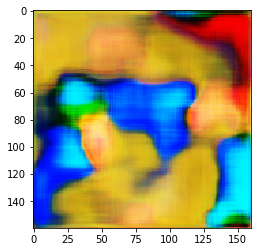

In [458]:
plt.imshow(gan.generator.predict(noise[1:2])[0]*0.5+0.5)

In [ ]:
pictures_small

In [143]:
z = Input(shape=(128,))
gan.generator.input

<tf.Tensor 'input_46_1:0' shape=(?, 160, 160, 3) dtype=float32>

In [ ]:
def build_generator():
    noise_shape = (128,)
    
    img_size = (160, 160, 3)
    upsample_layers = 5
    starting_filters = 64
    kernel_size = 3
    channels = 3

    # This block of code can be a little daunting, but essentially it automatically calculates the required starting
    # array size that will be correctly upscaled to our desired image size.
    #
    # We have 5 Upsample2D layers which each double the images width and height, so we can determine the starting
    # x size by taking (x / 2^upsample_count) So for our target image size, 256x192, we do the following:
    # x = (192 / 2^5), y = (256 / 2^5) [x and y are reversed within the model]
    # We also need a 3rd dimension which is chosen relatively arbitrarily, in this case it's 64.
    model = Sequential()
    model.add(
        Dense(starting_filters * (img_size[0] // (2 ** upsample_layers))  *  (img_size[1] // (2 ** upsample_layers)),
              activation="relu", input_shape=noise_shape))
    model.add(Reshape(((img_size[0] // (2 ** upsample_layers)),
                       (img_size[1] // (2 ** upsample_layers)),
                       starting_filters)))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())  # 6x8 -> 12x16
    model.add(Conv2D(1024, kernel_size=kernel_size, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())  # 12x16 -> 24x32
    model.add(Conv2D(512, kernel_size=kernel_size, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())  # 24x32 -> 48x64
    model.add(Conv2D(256, kernel_size=kernel_size, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())  # 48x64 -> 96x128
    model.add(Conv2D(128, kernel_size=kernel_size, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())  # 96x128 -> 192x256
    model.add(Conv2D(64, kernel_size=kernel_size, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(32, kernel_size=kernel_size, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(channels, kernel_size=kernel_size, padding="same"))
    model.add(Activation("tanh"))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)

    return Model(noise, img)

In [ ]:
# optimizer = RMSprop(lr=0.0002, decay=6e-8)
optimizer = Adam(0.0002, 0.5)
generator = build_generator()
generator.compile(loss='mean_squared_error', optimizer=optimizer,\
    metrics=['accuracy'])

In [108]:
testmodel = facenet_early
z = Input(shape=(160,160,3))

un_norm = Lambda(lambda x: (x * constant(127.5))+constant(127.5))
img = un_norm(z)

img_emb = testmodel(img)

id_combined2 = Model(z, img_emb)

In [111]:
id_combined2.outputs[1].name

'model_10_1/Bottleneck_BatchNorm/cond/Merge:0'

In [114]:
id_combined2.output_names

['model_10', 'model_10']

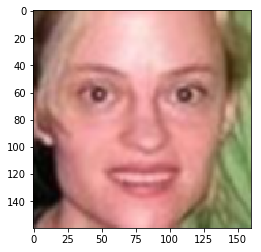

In [158]:
plt.imshow(pictures[1])

In [300]:
test = np.random.normal(0, 1, (1, 128))
# test = embeddings[1][106:107]+0.0
# test = np.zeros((1,128))
# test[0][0]

In [301]:
test = test / 2

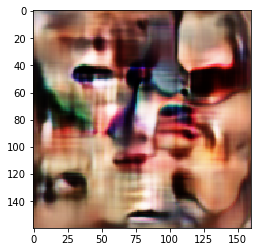

In [324]:
pic = gan.generator.predict(test - np.mean(test))
plt.imshow(pic[0]*0.5+0.5)

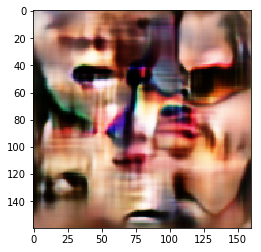

In [355]:
pic = gan.generator.predict(embeddings[1][106:107])
plt.imshow(pic[0]*0.5+0.5)

(array([ 1.,  2.,  2.,  5.,  3.,  4.,  5.,  4.,  7., 10.,  5.,  6.,  8.,
         7., 10.,  8., 11.,  7.,  5.,  4.,  5.,  2.,  3.,  2.,  0.,  1.,
         0.,  0.,  0.,  1.]),
 array([-2.6812193 , -2.4584448 , -2.2356703 , -2.0128958 , -1.7901213 ,
        -1.5673468 , -1.3445723 , -1.1217978 , -0.89902323, -0.6762487 ,
        -0.4534742 , -0.23069969, -0.00792518,  0.21484934,  0.43762386,
         0.66039836,  0.88317287,  1.1059474 ,  1.3287219 ,  1.5514964 ,
         1.7742709 ,  1.9970454 ,  2.21982   ,  2.4425945 ,  2.665369  ,
         2.8881435 ,  3.110918  ,  3.3336926 ,  3.556467  ,  3.7792416 ,
         4.002016  ], dtype=float32),
 <a list of 30 Patch objects>)

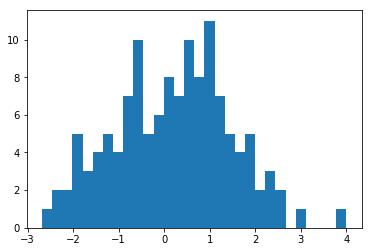

In [322]:
aaa = np.random.randint(10,1000)
test = embeddings[1][aaa:aaa+1]+0.0
plt.hist(test[0], bins=30)

In [323]:
np.std(embeddings[1][aaa:aaa+1])

1.2852229

In [224]:
%matplotlib inline

In [311]:
np.random.randint(10,1000)

614

array([-0.15698154,  0.13954364, -0.2730545 ,  0.7744649 ,  0.23055261,
        0.44942605,  0.7443857 , -0.7649528 , -0.7536028 , -1.7214955 ,
       -0.35132408, -1.254508  , -0.64573073,  1.2115946 , -0.8263079 ,
       -0.8001003 ,  0.8703015 , -1.2092865 , -0.10560033, -0.21615733,
       -0.65310216, -1.4633223 ,  0.7735441 ,  1.3425293 ,  0.8552281 ,
        1.9460685 ,  2.0074675 ,  0.03567301, -0.81779504, -1.9444289 ,
        0.6219084 ,  1.0668082 , -0.07238728,  0.57287794, -0.85255456,
        1.1076276 ,  1.2991029 , -1.1287085 ,  1.3197091 ,  0.51409614,
       -0.53060603, -0.01147844, -0.24313524, -0.9518913 , -0.26782042,
        1.7069795 ,  0.38524613,  0.23835762, -1.3981038 , -1.006814  ,
        0.61368775,  0.3401877 ,  1.2295238 ,  0.9490497 ,  0.4261839 ,
        3.5283084 ,  0.21215042, -1.7711014 ,  2.2762113 ,  0.90012544,
        0.11333194,  0.94972724,  1.0117462 ,  0.45113245, -0.3780327 ,
        0.31804878,  1.0071445 , -0.24169752,  0.2761042 ,  1.14

In [344]:
a = facenet_early.predict(pictures[0:1])

In [345]:
np.linalg.norm(a[1]-embeddings[1][0])

6.2114823e-06

In [346]:
facenet_early.trainable

False

In [348]:
gan.id_combined.trainable

AttributeError: 'DCGAN' object has no attribute 'id_combined'